# Week 7 - Vector Space Word Embeddings

This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them. Documents here are represented as densely indexed locations in dimensions, rather than sparse mixtures of topics (as in LDA topic modeling), so that distances between those documents (and words) are consistently superior, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

For this notebook we will be using the following packages

In [1]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

# Getting our corpora

Instead of downloading our corpora, we have download them in advance; a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `grimmerPressReleases`. We will load them into a DataFrame, but first we need to define a function to convert directories of text files into DataFrames:

In [2]:
def loadDir(targetDir, category):
    allFileNames = os.listdir(targetDir)
    #We need to make them into useable paths and filter out hidden files
    filePaths = [os.path.join(targetDir, fname) for fname in allFileNames if fname[0] != '.']

    #The dict that will become the DataFrame
    senDict = {
        'category' : [category] * len(filePaths),
        'filePath' : [],
        'text' : [],
    }

    for fPath in filePaths:
        with open(fPath) as f:
            senDict['text'].append(f.read())
            senDict['filePath'].append(fPath)

    return pandas.DataFrame(senDict)

Now we can use the function in all the directories in `data/grimmerPressReleases`

In [3]:
dataDir = '../data/grimmerPressReleases'

senReleasesDF = pandas.DataFrame()

for senatorName in [d for d in os.listdir(dataDir) if d[0] != '.']:
    senPath = os.path.join(dataDir, senatorName)
    senReleasesDF = senReleasesDF.append(loadDir(senPath, senatorName), ignore_index = True)

senReleasesDF[:100:10]

,category,filePath,text
0,Klobuchar,../data/grimmerPressReleases/Klobuchar/22May20...,...
10,Klobuchar,../data/grimmerPressReleases/Klobuchar/22Aug20...,...
20,Klobuchar,../data/grimmerPressReleases/Klobuchar/17Jul20...,...
30,Klobuchar,../data/grimmerPressReleases/Klobuchar/14Dec20...,...
40,Klobuchar,../data/grimmerPressReleases/Klobuchar/22Jan20...,...
50,Klobuchar,../data/grimmerPressReleases/Klobuchar/28May20...,...
60,Klobuchar,../data/grimmerPressReleases/Klobuchar/27Jun20...,...
70,Klobuchar,../data/grimmerPressReleases/Klobuchar/01Nov20...,...
80,Klobuchar,../data/grimmerPressReleases/Klobuchar/24Jan20...,...
90,Klobuchar,../data/grimmerPressReleases/Klobuchar/23Jan20...,...


Word2Vec needs to retain the sentence structure so as to capture a "continuous bag of words (CBOW)" and all of the skip-grams within a word window. The algorithm tries to preserve the distances induced by one of these two local structures. This is very different from clustering and LDA topic modeling which extract unordered words alone.

When we normalize here, we don't use the lematized form of the word because we might lose information. Note the paramter in the normalize tokens function.

In [4]:
#Apply our functions, notice each row is a list of lists now
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])

senReleasesDF[:100:10]

,category,filePath,text,tokenized_sents,normalized_sents
0,Klobuchar,../data/grimmerPressReleases/Klobuchar/22May20...,...,"[[Klobuchar, Features, Fergus, Falls, Bakery, ...","[[klobuchar, features, fergus, falls, bakery],..."
10,Klobuchar,../data/grimmerPressReleases/Klobuchar/22Aug20...,...,"[[Sen, Klobuchar, Showcases, Local, Efforts, t...","[[sen, klobuchar, showcases, local, efforts, c..."
20,Klobuchar,../data/grimmerPressReleases/Klobuchar/17Jul20...,...,"[[Klobuchar, Urges, Fellow, Senators, to, Supp...","[[klobuchar, urges, fellow, senators, support,..."
30,Klobuchar,../data/grimmerPressReleases/Klobuchar/14Dec20...,...,"[[Senator, Klobuchar, Wins, Passage, of, Cellu...","[[senator, klobuchar, wins, passage, cellulosi..."
40,Klobuchar,../data/grimmerPressReleases/Klobuchar/22Jan20...,...,"[[Klobuchar, Gives, Beyond, the, Yellow, Ribbo...","[[klobuchar, gives, yellow, ribbon], [place, a..."
50,Klobuchar,../data/grimmerPressReleases/Klobuchar/28May20...,...,"[[Sen, Klobuchar, Statement, in, Observance, o...","[[sen, klobuchar, statement, observance, memor..."
60,Klobuchar,../data/grimmerPressReleases/Klobuchar/27Jun20...,...,"[[Klobuchar, Secures, 2, 5, Million, for, Vete...","[[klobuchar, secures, veterans, education, hea..."
70,Klobuchar,../data/grimmerPressReleases/Klobuchar/01Nov20...,...,"[[Klobuchar, Carbon, Counter, Passes, First, C...","[[klobuchar, carbon, counter, passes, committe..."
80,Klobuchar,../data/grimmerPressReleases/Klobuchar/24Jan20...,...,"[[Sen, Klobuchar, Urges, Minnesotans, Travelin...","[[sen, klobuchar, urges, minnesotans, travelin..."
90,Klobuchar,../data/grimmerPressReleases/Klobuchar/23Jan20...,...,"[[Klobuchar, Co, sponsors, Emergency, LIHEAP, ...","[[klobuchar, co, sponsors, emergency, liheap, ..."


# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

To load our data our data we give all the sentences to the trainer:

In [5]:
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum())

Inside the word2vec object the words each have a vector. To access the vector directly, use the square braces (`__getitem__`) method:

In [6]:
senReleasesW2V['president'][:10] #Shortening because it's very large

array([-6.2267673e-01, -6.6667563e-01, -3.9667074e-02,  1.5444898e-03,
        3.7119046e-01, -1.8808110e+00,  1.0237701e+00, -1.1189166e+00,
        1.5473634e+00,  1.2444569e+00], dtype=float32)

If you want the full matrix, `syn0` stores all the vectors:

In [7]:
senReleasesW2V.wv.syn0

array([[-1.29856586e+00,  3.12571883e-01, -6.46152675e-01, ...,
         9.90776777e-01,  3.24493676e-01, -3.64532650e-01],
       [-5.22194020e-02,  8.59209478e-01,  3.19032729e-01, ...,
         3.52013648e-01, -1.16896284e+00,  2.74213433e-01],
       [-1.01878238e+00, -1.12904084e+00,  1.41845834e+00, ...,
         1.35756409e+00, -1.91561925e+00, -5.78513026e-01],
       ...,
       [ 4.52833958e-02,  2.88827904e-02,  1.05804885e-02, ...,
         3.02729080e-03, -1.60823800e-02,  1.90404593e-03],
       [ 7.31514394e-02,  7.75759444e-02, -3.27942707e-02, ...,
         1.56790502e-02, -5.40540777e-02,  1.08741418e-01],
       [ 1.27396733e-02,  3.58242914e-02, -1.09655457e-02, ...,
         4.18828800e-02, -6.01133378e-03,  1.43555487e-02]], dtype=float32)

Then, `index2word` lets you translate from the matrix to words:

In [8]:
senReleasesW2V.wv.index2word[10]

'american'

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

In [9]:
senReleasesW2V.most_similar('president')

[('administration', 0.8283464312553406),
 ('presidents', 0.7914415597915649),
 ('administrations', 0.7751102447509766),
 ('linean', 0.6842581629753113),
 ('cheney', 0.6636990308761597),
 ('rollback', 0.6445888876914978),
 ('responds', 0.6028443574905396),
 ('veto', 0.596078634262085),
 ('reserving', 0.5842287540435791),
 ('w.', 0.5778374671936035)]

In [10]:
senReleasesW2V.most_similar('war')

[('invade', 0.6993921995162964),
 ('wars', 0.6972939968109131),
 ('unresisted', 0.693369448184967),
 ('afghanistan', 0.6870641112327576),
 ('liberation', 0.6825169324874878),
 ('foment', 0.6709116101264954),
 ('disobedience', 0.6639421582221985),
 ('unwinnable', 0.6385154724121094),
 ('eviction', 0.6379228830337524),
 ('chaos', 0.6280709505081177)]

Find which word least matches the others within a word set (cosine similarity):

In [11]:
senReleasesW2V.doesnt_match(['administration', 'administrations', 'presidents', 'president', 'washington'])

'washington'

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [12]:
senReleasesW2V.most_similar(positive=['clinton', 'republican'], negative = ['democrat'])

[('reagan', 0.7111105918884277),
 ('nixon', 0.6991130113601685),
 ('signature', 0.67856764793396),
 ('roosevelt', 0.6618903875350952),
 ('bushs', 0.6556457281112671),
 ('bush', 0.6553600430488586),
 ('dwight', 0.6487621665000916),
 ('veto', 0.6264448165893555),
 ('ford', 0.6215455532073975),
 ('lyndon', 0.6209505796432495)]

Here we see that **Clinton + Republican - Democrat = Bush**. In other words, in this dataset, **Clinton** is to **Democrat** as **Bush** is to **Republican**. Whoah!

We can also save the vectors for later use:

In [13]:
senReleasesW2V.save("senpressreleasesWORD2Vec")

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [14]:
numWords = 50
targetWords = senReleasesW2V.wv.index2word[:numWords] #targetWords is a list of strings returned by their indexs from 0 to 49

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [15]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V[word]) #senReleasesW2V[word] is a vector associated with that word; thus wordsSubMatrix stores all the vectors of the top 50 words
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-1.2985659 ,  0.31257188, -0.6461527 , ...,  0.9907768 ,
         0.32449368, -0.36453265],
       [-0.0522194 ,  0.8592095 ,  0.31903273, ...,  0.35201365,
        -1.1689628 ,  0.27421343],
       [-1.0187824 , -1.1290408 ,  1.4184583 , ...,  1.3575641 ,
        -1.9156193 , -0.578513  ],
       ...,
       [ 0.7261309 ,  1.0728214 , -0.25613877, ..., -1.4942498 ,
         1.37964   , -1.0396935 ],
       [-0.45212147,  1.9865396 , -0.5438519 , ...,  0.1781534 ,
         0.72487944, -0.35405028],
       [ 2.120718  ,  1.1636872 , -2.078742  , ...,  1.6376282 ,
         1.7728649 ,  2.885328  ]], dtype=float32)

Then we can use PCA to reduce the dimesions (e.g., to 50), and T-SNE to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [16]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

We now can plot the points

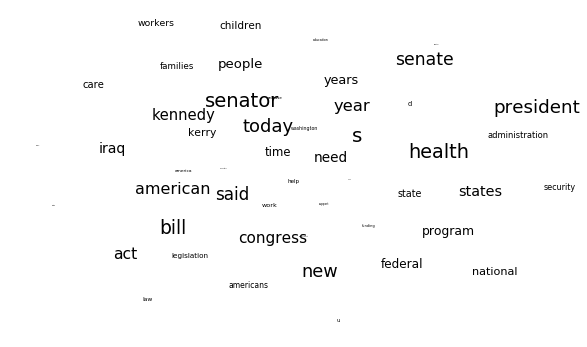

In [17]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

My visualization above puts ``said`` next to ``congress`` and ``bill`` near ``act``. ``health`` is beside ``care`` and ``national`` abuts ``security``.

# Chinese examples

In [19]:
model=gensim.models.Word2Vec.load('../data/1992embeddings_hs_new3.sg')

## analogy

King+man-Queen? A few examples based on a corpus of Chinese news. 

First, location analogy: **province -> capital**

In [20]:
mm = model.most_similar(positive=[u'长沙',u'陕西'], negative=[u'湖南']) # Changsha + Shaanxi - Hunan
for m in mm:
    print(m[0],m[1])
    print("Xi'an")
    break

西安 0.36609965562820435
Xi'an


In [21]:
mm = model.most_similar(positive=[u'广州',u'湖北'], negative=[u'广东']) # Guangzhou + Hubei - Guangdong
for m in mm:
    print(m[0],m[1])
    print("Wuhan")
    break

武汉 0.3677000403404236
Wuhan


Second, location analogy: **country -> capital**

In [22]:
mm = model.most_similar(positive=[u'东京',u'美国'], negative=[u'日本']) # Tokyo + US - Japan
for m in mm:
    print(m[0],m[1])
    print("(Washington DC)")
    break

华盛顿 0.508813738822937
(Washington DC)


## similar words

In [23]:
word = u'社会主义'  #socialism
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss: # I'm guessing ss returns a list of tuples just like Most_similar() returns list of tuples('words', similarity)
    print(s[0])
print("")

the most similar words to 社会主义 is: 
特色
市场经济
理论
建设
改革开放
马克思主义
党
经济体制
基本路线
现代化



In [24]:
word = u'玉米'  # corn
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 玉米 is: 
小麦
水稻
作物
棉花
新品种
杂交
大豆
增产
栽培
农作物



## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project using at least two different specification of `word2vec`, and visualize them each with two separate visualization layout specifications (e.g., TSNE, PCA). Then interrogate critical word vectors within your corpus in terms of the most similar words, analogies, and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the semantic organization of words in your corpora? Which estimation and visualization specification generate the most insight and appear the most robustly supported and why? 

<span style="color:red">***Stretch***: Explore different vector calculations beyond addition and subtraction, such as multiplication, division or some other function. What does this exploration reveal about the semantic structure of your corpus?

For this exercise, I will be using a corpus of movie plots sc (I'm working on collecting data for my final project).


In [2]:
##import csv
wiki_df = pandas.read_csv(os.path.join(os.getcwd(), 'wiki_movie_plots_deduped.csv'))
wiki_df.head(10)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...
5,1903,Alice in Wonderland,American,Cecil Hepworth,May Clark,unknown,https://en.wikipedia.org/wiki/Alice_in_Wonderl...,"Alice follows a large white rabbit down a ""Rab..."
6,1903,The Great Train Robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...
7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...
8,1905,The Little Train Robbery,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Little_Train...,The opening scene shows the interior of the ro...
9,1905,The Night Before Christmas,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Night_Before...,Scenes are introduced using lines of the poem....


In [3]:
wiki_df.shape

(34886, 8)

In [4]:
wiki_df_1 = wiki_df[0:3488]
wiki_df_1.shape

(3488, 8)

In [5]:
wiki_df_1[-1:]

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
3487,1943,The Adventures of Smilin' Jack,American,"Lewis D. Collins, Ray Taylor","Tom Brown, Rose Hobart, Marjorie Lord, Keye Lu...",serial,https://en.wikipedia.org/wiki/The_Adventures_o...,"In 1941, an American aviator, 'Smilin' Jack' M..."


In [47]:
#tokenize and normalize without lemmanization
wiki_df_1['tokenized_sents'] = wiki_df_1['Plot'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
wiki_df_1['normalized_sents'] = wiki_df_1['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])

wiki_df_1[:100:10]

/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,tokenized_sents,normalized_sents
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr...","[[A, bartender, is, working, at, a, saloon, se...","[[bartender, working, saloon, serving, drinks,..."
10,1906,Dream of a Rarebit Fiend,American,Wallace McCutcheon and Edwin S. Porter,NaN,short,https://en.wikipedia.org/wiki/Dream_of_a_Rareb...,The Rarebit Fiend gorges on Welsh rarebit at a...,"[[The, Rarebit, Fiend, gorges, on, Welsh, rare...","[[rarebit, fiend, gorges, welsh, rarebit, rest..."
20,1908,A Christmas Carol,American,Unknown,Tom Ricketts,drama,https://en.wikipedia.org/wiki/A_Christmas_Caro...,No prints of the first American film adaptatio...,"[[No, prints, of, the, first, American, film, ...","[[prints, american, film, adaptation, christma..."
30,1910,The House with Closed Shutters,American,D.W. Griffith,Henry B. Walthall,drama,https://en.wikipedia.org/wiki/The_House_with_C...,During the American Civil War a young soldier ...,"[[During, the, American, Civil, War, a, young,...","[[american, civil, war, young, soldier, loses,..."
40,1911,David Copperfield,American,Theodore Marston,"Marie Eline, Florence La Badie, Mignon Anderso...",drama,https://en.wikipedia.org/wiki/David_Copperfiel...,"""David Copperfield consists of three reels and...","[[David, Copperfield, consists, of, three, ree...","[[david, copperfield, consists, reels, separat..."
50,1912,An Unseen Enemy,American,D. W. Griffith,"Lillian Gish, Dorothy Gish",unknown,https://en.wikipedia.org/wiki/An_Unseen_Enemy,A physician's death orphans his two adolescent...,"[[A, physician, 's, death, orphans, his, two, ...","[[physician, death, orphans, adolescent, daugh..."
60,1913,The Telephone Girl and the Lady,American,D.W. Griffith,"Mae Marsh, Claire McDowell",drama,https://en.wikipedia.org/wiki/The_Telephone_Gi...,A telephone operator is walking out with a han...,"[[A, telephone, operator, is, walking, out, wi...","[[telephone, operator, walking, handsome, poli..."
70,1914,Cinderella,American,James Kirkwood,"Mary Pickford, Owen Moore, Isobel Vernon",fantasy drama,https://en.wikipedia.org/wiki/Cinderella_(1914...,Cinderella is a kind young woman who lives wit...,"[[Cinderella, is, a, kind, young, woman, who, ...","[[cinderella, kind, young, woman, lives, wicke..."
80,1914,Charlie Chaplin,American,"Charlie Chaplin, Mabel Normand",Comedy,unknown,https://en.wikipedia.org/wiki/His_Trysting_Place,Charlie and his friend Ambrose meet in a resta...,"[[Charlie, and, his, friend, Ambrose, meet, in...","[[charlie, friend, ambrose, meet, restaurant, ..."
90,1914,Making a Living,American,Henry Lehrman,"Charlie Chaplin, Virginia Kirtley, Alice Daven...",comedy,https://en.wikipedia.org/wiki/Making_a_Living,Chaplin's character attempts to convince a pas...,"[[Chaplin, 's, character, attempts, to, convin...","[[chaplin, character, attempts, convince, pass..."


In [17]:
#help(lucem_illud_2020.normalizeTokens)

Help on function normalizeTokens in module lucem_illud_2020.proccessing:

normalizeTokens(word_list, extra_stop=[], model=<spacy.lang.en.English object at 0x1a1e8957d0>)



In [274]:
#train the data with word2vec
#wiki_W2V = gensim.models.word2vec.Word2Vec(wiki_df_1['normalized_sents'].sum())
wiki_W2V = gensim.models.word2vec.Word2Vec(wiki_df_1['normalized_sents'].sum(), hs=1, negative = 0)

In [49]:
#look at top 50 words from the set 
numwords=50
wiki_topWords = wiki_W2V.wv.index2word[:numwords] #wiki_topWords is a list of strings returned by their indexs from 0 to 49

In [190]:
print(wiki_topWords)

['love', 'new', 'man', 'father', 'tells', 'home', 'money', 'wife', 'finds', 'later', 'goes', 'young', 'takes', 'time', 'away', 'police', 'life', 'john', 'marry', 'tries', 'find', 'night', 'mary', 'gets', 'men', 'friend', 'daughter', 'family', 'day', 'returns', 'woman', 'house', 'film', 'leaves', 'decides', 'husband', 'mother', 'bill', 'son', 'help', 'tom', 'soon', 'leave', 'town', 'girl', 'way', 'comes', 'asks', 'joe', 'old']


In [50]:
#create submatrix that stores the vectors of the top 50 words
wikiSubMatrix = []
for word in wiki_topWords: # GOT_topWords is a list of strings/words
    wikiSubMatrix.append(wiki_W2V[word])
wikiSubMatrix = np.array(wikiSubMatrix)
wikiSubMatrix


array([[-0.6681044 , -1.5818236 , -0.34616885, ..., -0.95661634,
        -1.2458214 ,  0.3823006 ],
       [-0.85342634,  0.19786014,  0.85423905, ...,  1.388798  ,
         0.5803119 , -0.25079727],
       [-0.8266549 , -1.1104606 , -0.41458997, ..., -0.29765877,
        -0.00491285,  0.67207044],
       ...,
       [-0.6960822 , -0.7129166 , -0.01374649, ..., -0.24683008,
        -0.07452687,  0.32812315],
       [-0.64712554, -0.541268  ,  0.08686949, ..., -0.18677497,
         0.00967789,  0.34020147],
       [-0.6222015 , -0.73964405,  0.07873531, ...,  0.05875105,
        -0.00890474,  0.24173252]], dtype=float32)

In [51]:
#PCA dimension reduction to 50 components
wiki_pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wikiSubMatrix)
wiki_reducedPCA_data = wiki_pcaWords.transform(wikiSubMatrix)
#T-SNE
wiki_tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(wiki_reducedPCA_data)

#pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
#reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
#tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

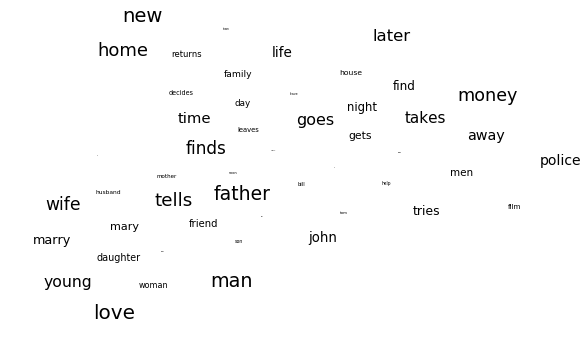

In [52]:
#plot using TSNE
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(wiki_tsneWords[:, 0], wiki_tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(wiki_topWords):
    ax.annotate(word, (wiki_tsneWords[:, 0][i],wiki_tsneWords[:, 1][i]), size =  20 * (numwords - i) / numwords)
plt.xticks(())
plt.yticks(())
plt.show()


This plot shows that in my corpus, "money" is semantically linked with "takes" "away", suggesting that in my corpus, money is associated with property loss. Also, this group of words ("money", "takes", "away") are also located near the words "police", indicating the relation between property loss and law enforcement officers. That is, in my corpora, the semantic relation between law enforcement officers and loss of money is close. This seems to be an oversimplificaiton of what happens in reality when money is lost, but at least it suggests that movies tend to group these two things together, namely, money loss and police officers. 

Another interesting pattern to notice in the graph is the semantic closeness of word vectors of "marry", "young", "daughter, "woman", "love", and "wife". This group of words are located adjacent to one another. This seems to suggest that the "love" described and portrayed in my corpora often involve marriage of young women/daughters. This indicates that the movies reflect traditional heterosexual normativity because "love" is located semantically near "young" "daughter" and "marriage". 

In [166]:
# similarities - the most similar words
wiki_W2V.most_similar('marry')

[('mary', 0.9680055379867554),
 ('married', 0.9621591567993164),
 ('daughter', 0.9560495615005493),
 ('husband', 0.9434925317764282),
 ('meets', 0.9405574202537537),
 ('wife', 0.9404036998748779),
 ('wealthy', 0.9297769069671631),
 ('ann', 0.9266442060470581),
 ('girl', 0.9255068302154541),
 ('beautiful', 0.9253402948379517)]

In [171]:
wiki_W2V.most_similar('girl')

[('beautiful', 0.9843993782997131),
 ('wealthy', 0.982239305973053),
 ('meets', 0.9803317189216614),
 ('married', 0.9717669486999512),
 ('ann', 0.970119059085846),
 ('loretta', 0.9676691293716431),
 ('lady', 0.9663709998130798),
 ('daughter', 0.965384840965271),
 ('joan', 0.9649609923362732),
 ('husband', 0.9649244546890259)]

In [169]:
wiki_W2V.most_similar('love')

[('niagara', 0.8374338150024414),
 ('young', 0.7419917583465576),
 ('asleep', 0.7401240468025208),
 ('daughter', 0.7366063594818115),
 ('loves', 0.7365449666976929),
 ('woman', 0.7322948575019836),
 ('marry', 0.721499502658844),
 ('meets', 0.7112553119659424),
 ('named', 0.6962175369262695),
 ('man', 0.6954386830329895)]

In [177]:
wiki_W2V.most_similar('old')

[('mother', 0.9651621580123901),
 ('wealthy', 0.9619306325912476),
 ('son', 0.9535173177719116),
 ('good', 0.950468897819519),
 ('rich', 0.9498522281646729),
 ('naïve', 0.9467563629150391),
 ('wants', 0.946628987789154),
 ('child', 0.9462471008300781),
 ('divorce', 0.9453333616256714),
 ('couple', 0.9450294971466064)]

In [188]:
wiki_W2V.most_similar('money')

[('$', 0.9785839319229126),
 ('job', 0.9713992476463318),
 ('house', 0.9711761474609375),
 ('place', 0.9685046076774597),
 ('find', 0.9680398106575012),
 ('ship', 0.9662396907806396),
 ('train', 0.9656243324279785),
 ('station', 0.9638852477073669),
 ('order', 0.9634459018707275),
 ('offers', 0.962308406829834)]

In [194]:
# similarities - analogies: x+Y-Z = 
wiki_W2V.most_similar(positive=['husband', 'man'], negative = ['wife'])

[('woman', 0.962547242641449),
 ('named', 0.9310775399208069),
 ('daughter', 0.9153832793235779),
 ('loretta', 0.9069594144821167),
 ('john', 0.9024914503097534),
 ('loves', 0.899837851524353),
 ('realizes', 0.8983882069587708),
 ('hutton', 0.8961410522460938),
 ('sister', 0.8894416689872742),
 ('robert', 0.8875981569290161)]

In [205]:
#wiki_W2V.most_similar(positive=['man', 'woman'], negative = ['boy'])

[('young', 0.7792699337005615),
 ('daughter', 0.7665567398071289),
 ('named', 0.7382898926734924),
 ('love', 0.7166443467140198),
 ('loves', 0.6833287477493286),
 ('mary', 0.6534551382064819),
 ('meets', 0.6507006883621216),
 ('marry', 0.6479809284210205),
 ('fallen', 0.6468356847763062),
 ('falls', 0.6463195085525513)]

These words returned by most_similar suggests the movies have a very stereotypical depiction of marriage, girlhood, and old age. "Marry" is similar to husband and wife, and suggest heterosexual relationships. "girl" is similar to "young", "marry", "asleep", and "husband", which suggests that in my corpus, when "girl" is mentioned in the movie, they are often mentioned in the context of their husband and their future marriage. This suggests that girls depicted in these movies are mostly not independent; hence they reflect and might reinforce patriarchical values/ norms.  

In [207]:
# differences - least match
wiki_W2V.doesnt_match(['boys','daughters','kids','children'])


'children'

Plural forms of different kinds can be distinguished. 

In [192]:
wiki_W2V.doesnt_match(['train','car','plane','bike','toy'])

'train'

# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [22]:
apsDF = pandas.read_csv('../data/APSabstracts1950s.csv', index_col = 0)
apsDF[:10]

,copyrightYear,doi,abstract
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...
5,1951,10.1103/RevModPhys.23.311,A brief account is given of Dyson's proof of t...
6,1951,10.1103/RevModPhys.23.315,A systematics is given of all transitions for ...
7,1951,10.1103/RevModPhys.23.322,A systematics of the -transitions of even A nu...
8,1951,10.1103/RevModPhys.23.328,The available experiments on the absorption sp...
9,1952,10.1103/RevModPhys.24.108,The classical theory of the dynamics of viscou...


We will load these as documents into Word2Vec, but first we need to normalize and pick some tags.

In [23]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [24]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

In [25]:
apsDF[:10]

,copyrightYear,doi,abstract,tokenized_words,normalized_words
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...,"[A, summarizing, account, is, given, of, the, ...","[summarizing, account, given, research, barium..."
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...,"[New, tables, of, coulomb, functions, are, pre...","[new, tables, coulomb, functions, presented, i..."
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...,"[Ionization, by, electron, impact, in, diatomi...","[ionization, electron, impact, diatomic, gases..."
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...,"[It, is, shown, that, the, conductivity, in, t...","[shown, conductivity, ohmic, cuprous, oxide, l..."
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...,"[The, factorization, method, is, an, operation...","[factorization, method, operational, procedure..."
5,1951,10.1103/RevModPhys.23.311,A brief account is given of Dyson's proof of t...,"[A, brief, account, is, given, of, Dyson, 's, ...","[brief, account, given, dyson, proof, finitene..."
6,1951,10.1103/RevModPhys.23.315,A systematics is given of all transitions for ...,"[A, systematics, is, given, of, all, transitio...","[systematics, given, transitions, odd, nuclei,..."
7,1951,10.1103/RevModPhys.23.322,A systematics of the -transitions of even A nu...,"[A, systematics, of, the, -transitions, of, ev...","[systematics, -transitions, nuclei, given, int..."
8,1951,10.1103/RevModPhys.23.328,The available experiments on the absorption sp...,"[The, available, experiments, on, the, absorpt...","[available, experiments, absorption, spectra, ..."
9,1952,10.1103/RevModPhys.24.108,The classical theory of the dynamics of viscou...,"[The, classical, theory, of, the, dynamics, of...","[classical, theory, dynamics, viscous, fluids,..."


In [26]:
taggedDocs = [] #docKeywords= [[first documents' keywords, first document's copyrightYear, first document's doi],[second]]
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']] # docKeywords stores all the keywords contained in that row's normalized column; basically find all the keywords that are mentioned in that row's 'normalized_words' column, for instance, if that row's normalized column contains two keywords, return those two keywords. (that is, if any of the words in keywords is in the that row's 'normalized_words' column, return those)for s in keywords (iterate the keywords in keywords list), if s is row['normalized_words'], return s
    docKeywords.append(row['copyrightYear']) # append that row's 'copyrightYear' column
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

In [30]:
docKeywords[0]

'proton'

In [32]:
apsDF['normalized_words'][0]

['summarizing',
 'account',
 'given',
 'research',
 'barium',
 'titanate',
 'progress',
 'laboratory',
 'insulation',
 'research',
 'm.',
 'i.',
 't.',
 'investigations',
 'led',
 'understanding',
 'mechanism',
 'ferroelectricity',
 'titanates',
 'discoveries',
 'piezoelectric',
 'effect',
 'ceramics',
 'domain',
 'structure',
 'single',
 'crystals',
 'batio3',
 'high',
 'dielectric',
 'constant',
 'field',
 'strength',
 'temperature',
 'sensitivity',
 'piezo',
 'response',
 'barium',
 'titanate',
 'dielectrics',
 'useful',
 'numerous',
 'technical',
 'applications']

In [35]:
taggedDocs[0] #10.1103/RevModPhys.22.221

LabeledSentence(words=['summarizing', 'account', 'given', 'research', 'barium', 'titanate', 'progress', 'laboratory', 'insulation', 'research', 'm.', 'i.', 't.', 'investigations', 'led', 'understanding', 'mechanism', 'ferroelectricity', 'titanates', 'discoveries', 'piezoelectric', 'effect', 'ceramics', 'domain', 'structure', 'single', 'crystals', 'batio3', 'high', 'dielectric', 'constant', 'field', 'strength', 'temperature', 'sensitivity', 'piezo', 'response', 'barium', 'titanate', 'dielectrics', 'useful', 'numerous', 'technical', 'applications'], tags=[1950, '10.1103/RevModPhys.22.221'])

In [28]:
apsDF[:10]

,copyrightYear,doi,abstract,tokenized_words,normalized_words,TaggedAbstracts
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...,"[A, summarizing, account, is, given, of, the, ...","[summarizing, account, given, research, barium...","([summarizing, account, given, research, bariu..."
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...,"[New, tables, of, coulomb, functions, are, pre...","[new, tables, coulomb, functions, presented, i...","([new, tables, coulomb, functions, presented, ..."
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...,"[Ionization, by, electron, impact, in, diatomi...","[ionization, electron, impact, diatomic, gases...","([ionization, electron, impact, diatomic, gase..."
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...,"[It, is, shown, that, the, conductivity, in, t...","[shown, conductivity, ohmic, cuprous, oxide, l...","([shown, conductivity, ohmic, cuprous, oxide, ..."
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...,"[The, factorization, method, is, an, operation...","[factorization, method, operational, procedure...","([factorization, method, operational, procedur..."
5,1951,10.1103/RevModPhys.23.311,A brief account is given of Dyson's proof of t...,"[A, brief, account, is, given, of, Dyson, 's, ...","[brief, account, given, dyson, proof, finitene...","([brief, account, given, dyson, proof, finiten..."
6,1951,10.1103/RevModPhys.23.315,A systematics is given of all transitions for ...,"[A, systematics, is, given, of, all, transitio...","[systematics, given, transitions, odd, nuclei,...","([systematics, given, transitions, odd, nuclei..."
7,1951,10.1103/RevModPhys.23.322,A systematics of the -transitions of even A nu...,"[A, systematics, of, the, -transitions, of, ev...","[systematics, -transitions, nuclei, given, int...","([systematics, -transitions, nuclei, given, in..."
8,1951,10.1103/RevModPhys.23.328,The available experiments on the absorption sp...,"[The, available, experiments, on, the, absorpt...","[available, experiments, absorption, spectra, ...","([available, experiments, absorption, spectra,..."
9,1952,10.1103/RevModPhys.24.108,The classical theory of the dynamics of viscou...,"[The, classical, theory, of, the, dynamics, of...","[classical, theory, dynamics, viscous, fluids,...","([classical, theory, dynamics, viscous, fluids..."


In [63]:
apsDF['TaggedAbstracts'][0]

LabeledSentence(words=['summarizing', 'account', 'given', 'research', 'barium', 'titanate', 'progress', 'laboratory', 'insulation', 'research', 'm.', 'i.', 't.', 'investigations', 'led', 'understanding', 'mechanism', 'ferroelectricity', 'titanates', 'discoveries', 'piezoelectric', 'effect', 'ceramics', 'domain', 'structure', 'single', 'crystals', 'batio3', 'high', 'dielectric', 'constant', 'field', 'strength', 'temperature', 'sensitivity', 'piezo', 'response', 'barium', 'titanate', 'dielectrics', 'useful', 'numerous', 'technical', 'applications'], tags=[1950, '10.1103/RevModPhys.22.221'])

Now we can train a Doc2Vec model:

In [37]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words. 

In [38]:
apsD2V.docvecs[1952]

array([-0.04016161,  1.2180867 ,  1.0271825 , -0.13982609, -0.78874904,
        0.9522371 , -0.9291611 , -1.2605413 , -1.2883214 , -1.0809015 ,
       -1.018789  , -0.48057583, -0.47353327, -0.7791113 , -1.4337499 ,
        0.9710901 ,  0.632361  , -1.8005762 ,  0.07872047, -0.8183049 ,
        1.3014797 ,  1.1676594 ,  0.63520914, -0.18592583,  1.180814  ,
       -0.26138252, -1.0281413 ,  1.401724  , -0.35779145, -1.0842392 ,
        0.16343854, -0.6111898 , -0.30762705,  0.21378341, -0.04657753,
       -0.52964944,  0.28192362, -1.7311515 ,  0.40889695,  0.66195285,
        0.13034284, -2.1844425 ,  1.2432133 ,  1.0168946 ,  1.225236  ,
       -0.3329089 , -1.2329998 , -0.05425806, -1.0503834 ,  2.3821967 ,
        0.11824647, -1.0818378 , -0.96104914,  0.4500083 ,  1.0377505 ,
       -2.1688044 ,  1.3005028 ,  0.84546715, -0.8733727 ,  0.58096135,
        0.5112367 ,  0.847233  , -1.4617687 ,  0.5313006 ,  1.2793884 ,
       -1.085649  ,  0.7626071 ,  2.127462  ,  0.9567326 ,  1.19

In [39]:
#apsD2V.docvecs['10.1103/RevModPhys.24.108']

array([ 0.02604651,  0.0281859 ,  0.06737747,  0.11851418,  0.05859349,
       -0.06545577,  0.04980798, -0.02783124, -0.03586634, -0.04412324,
       -0.10186347,  0.05374407, -0.01338808,  0.10676749, -0.03957034,
       -0.1391723 , -0.03373826, -0.00446488, -0.04116573,  0.03192503,
       -0.00917051, -0.02784491, -0.01371252, -0.02280309,  0.06401711,
        0.04324067,  0.0579525 ,  0.02177742,  0.05096382,  0.00773783,
       -0.03351769, -0.0628501 ,  0.02043983,  0.0072732 ,  0.0772434 ,
       -0.02688627,  0.00712469,  0.03497161,  0.11268404, -0.0222383 ,
       -0.01818055,  0.01904719, -0.04606286,  0.04822603,  0.004699  ,
       -0.04342765, -0.07590108, -0.01250354, -0.06502869,  0.09928435,
        0.03160552,  0.01469826,  0.01919071,  0.01823465, -0.00430664,
       -0.01571437,  0.0419362 , -0.03057909,  0.04712641,  0.04586441,
       -0.00890118,  0.00381645,  0.00910546,  0.05628848, -0.03141072,
        0.04914179,  0.05268342,  0.032701  ,  0.00895163,  0.10

The words can still be accessed in the same way:

In [31]:
apsD2V['atom']

array([ 0.18284628, -0.04895942, -0.89525455,  0.386619  ,  0.15722378,
        0.28620473,  0.34100235,  0.6834194 , -0.00408947,  0.6566478 ,
       -0.5354382 ,  0.01004452,  0.43740138, -1.091602  ,  0.22807835,
        0.71692365, -0.37653923, -0.10362295, -0.16604191,  0.3131635 ,
       -0.35241136, -0.8172237 ,  0.3936495 , -0.5299927 ,  0.13411738,
        0.2986211 , -0.45632944,  0.00526831,  0.7483204 , -0.34703842,
       -0.8986433 , -0.25062317,  0.16325492, -1.1789956 ,  0.1183672 ,
        0.30810228, -1.107009  ,  0.42208552,  0.41748974,  0.7264739 ,
        0.8722728 ,  1.4183432 , -0.25191745,  0.8265018 ,  0.19808555,
        0.23069115, -0.17685364, -0.29582533,  0.05870611,  0.10616075,
       -0.45562714,  0.17342158, -0.25422886,  0.7015164 ,  0.7497404 ,
       -0.07426755,  1.2640078 , -0.19158858, -0.70047724,  0.10496335,
       -0.91657907, -0.8523482 ,  0.6237608 , -0.09004818,  0.08607046,
       -0.2238795 ,  0.4310083 , -0.21755084, -1.1692094 , -0.53

We can still use the ``most_similar`` command to perform simple semantic equations:

In [32]:
apsD2V.most_similar(positive = ['atom','electrons'], negative = ['electron'], topn = 1)

[('atoms', 0.808495819568634)]

This is interesting. **Electron** is to **electrons** as **atom** is to **atoms**. Another way to understand this, developed below is: **electrons - electron** induces a singular to plural dimension, so when we subtract **electron** from **atom** and add **electrons**, we get **atoms**! 

In [40]:
apsD2V.most_similar(positive = ['einstein','law'], negative = ['equation'], topn = 1)

[('hypotheses', 0.9400321245193481)]

In other words **Einstein** minus **equation** plus **law** equals **Meissner**--Walthur Meissner studied mechanical engineering and physics ... and was more likely to produce a "law" than a "equation", like the Meissner effect, the damping of the magnetic field in superconductors. If we built our word-embedding with a bigger corpus like the entire arXiv, a massive repository of physics preprints, we would see many more such relationships like **gravity - Newton + Einstein = relativity**.

We can also compute all of these *by hand*--explicitly wth vector algebra: 

In [34]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'].reshape(1,-1), apsD2V['positron'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

array([[0.63588536]], dtype=float32)

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

In [35]:
apsD2V.docvecs.most_similar([ apsD2V['electron'] ], topn=5 )

[('10.1103/PhysRev.113.479', 0.6609346866607666),
 ('10.1103/PhysRev.104.1528', 0.6466891169548035),
 ('10.1103/PhysRev.110.857', 0.6089353561401367),
 ('10.1103/PhysRev.106.191', 0.6088852882385254),
 ('10.1103/PhysRev.100.1646', 0.6056019067764282)]

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:

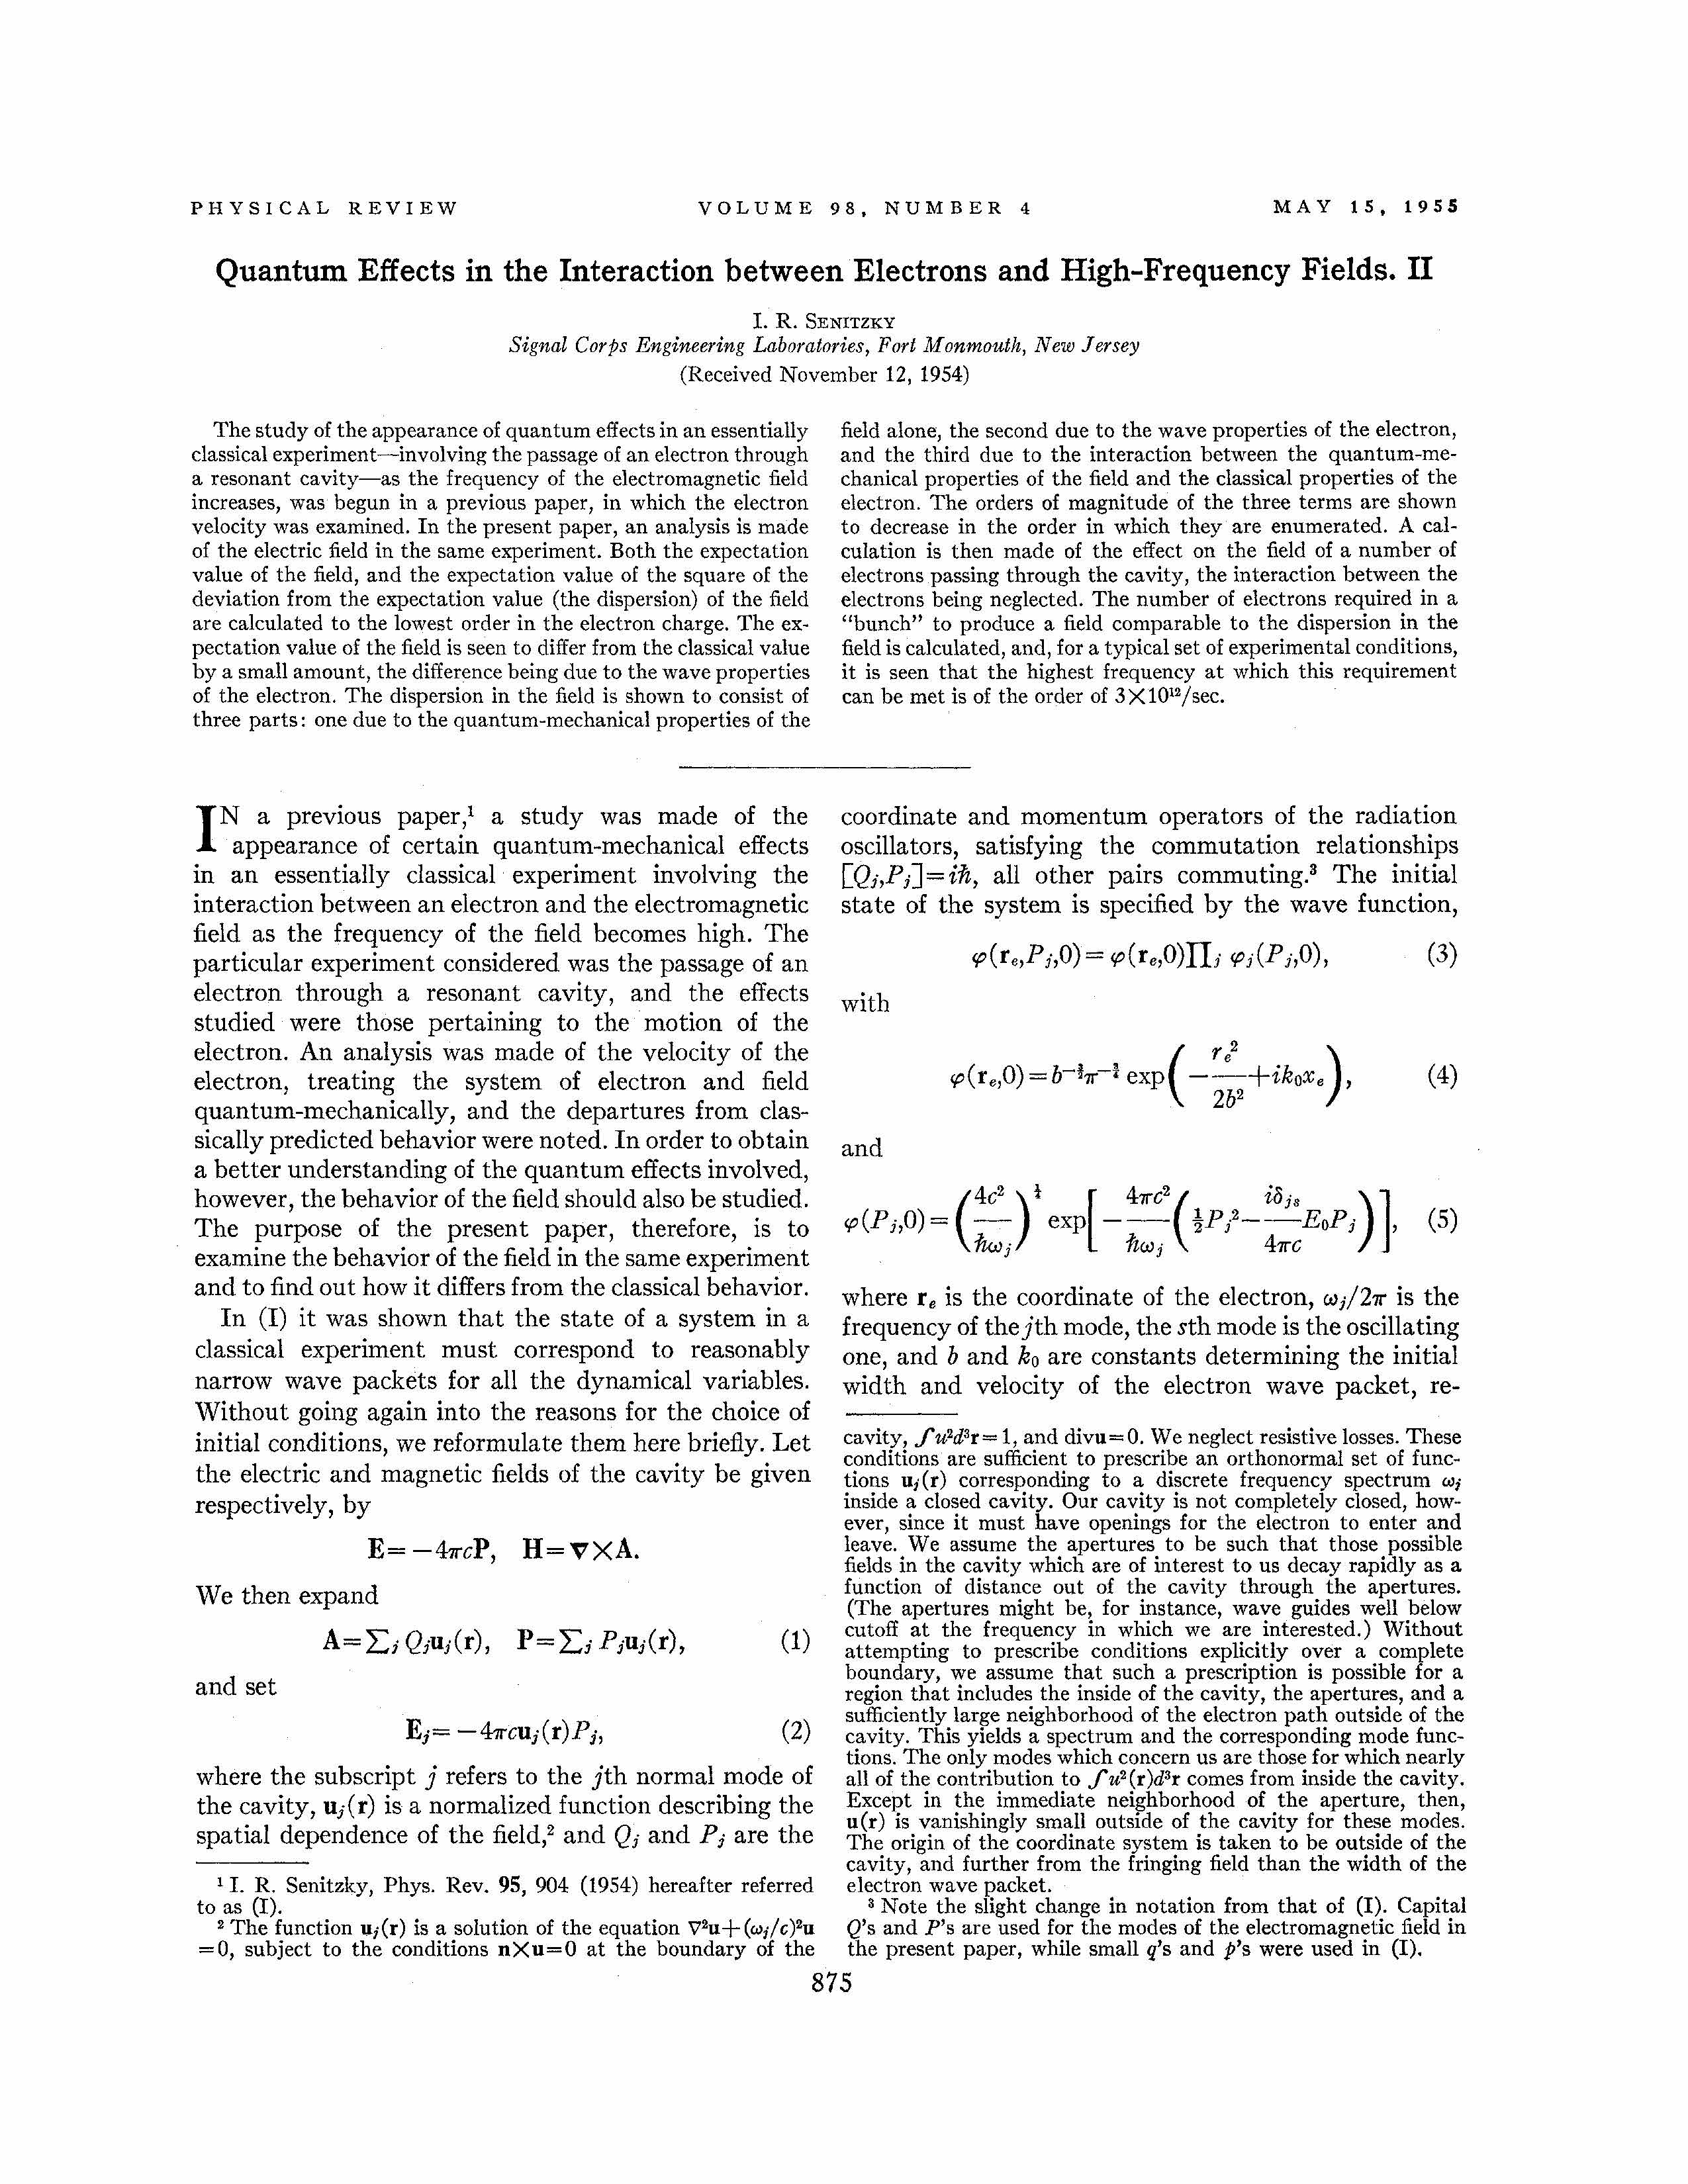

In [36]:
from IPython.display import Image
Image("../data/PhysRev.98.875.jpg", width=1000, height=1000)

Now let's go the other way around and find words most similar to this document:

In [37]:
apsD2V.most_similar( [ apsD2V.docvecs['10.1103/PhysRev.98.875'] ], topn=5) 

[('volts', 0.8236003518104553),
 ('attaining', 0.8067859411239624),
 ('shielding', 0.7597390413284302),
 ('kv', 0.7478094100952148),
 ('vary', 0.7477940917015076)]

We can even look for documents most like a query composed of multiple words:

In [38]:
apsD2V.docvecs.most_similar([ apsD2V['electron']+apsD2V['positron']+apsD2V['neutron']], topn=5 )

[('10.1103/PhysRev.85.1012', 0.7578761577606201),
 ('10.1103/PhysRev.89.631', 0.7375411987304688),
 ('10.1103/PhysRev.108.570', 0.7350585460662842),
 ('10.1103/PhysRev.116.1583', 0.7231032848358154),
 ('10.1103/PhysRev.92.1218', 0.7129611968994141)]

Now let's plot some words and documents against one another with a heatmap:

In [39]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

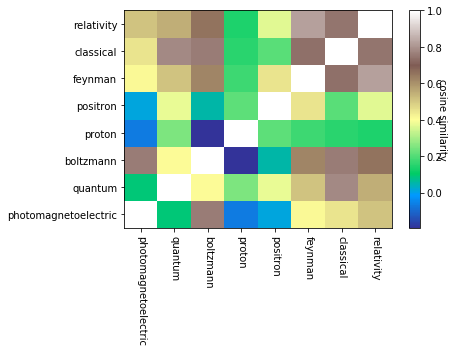

In [40]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [41]:
targetDocs = apsDF['doi'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

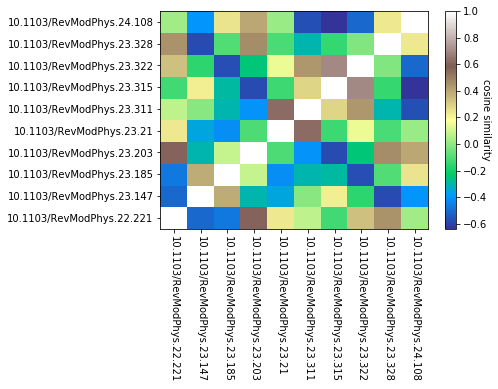

In [42]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [43]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

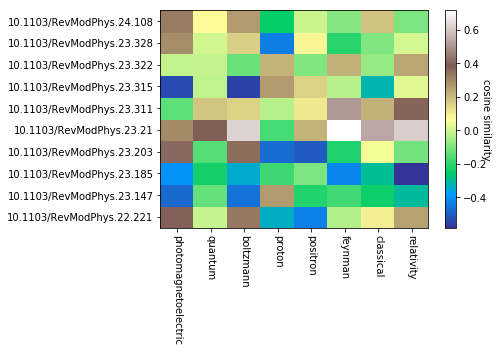

In [44]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [45]:
apsD2V.save('apsW2V')

We can later load it:

In [46]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project using `doc2vec`, and explore the relationship between different documents and the word vectors you analyzed in the last exercise. Consider the most similar words to critical documents, analogies (doc _x_ + word _y_), and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the documentary organization of your semantic space?

In [108]:
#wiki_df[-10:]

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
34876,2013,Selam,Turkish,Levent Demirkale,"Bucin Abdullah, Selma Alispahic, Tina Cvitanov...",drama,https://en.wikipedia.org/wiki/Selam_(film),The film opens with a Senegalese boy named Kha...
34877,2013,Particle (film),Turkish,Erdem Tepegöz,"Jale Arıkan, Rüçhan Caliskur, Özay Fecht, Remz...",drama film,https://en.wikipedia.org/wiki/Particle_(film),"Zeynep lost her job at weaving factory, and he..."
34878,2014,Mandıra Filozofu,Turkish,Director: Müfit Can Saçıntı,Director: Müfit Can Saçıntı\r\nCast: Rasim Özt...,unknown,https://en.wikipedia.org/wiki/Mand%C4%B1ra_Fil...,Cavit an ambitious industralist in İstanbul pl...
34879,2014,Winter Sleep,Turkish,Director: Nuri Bilge Ceylan,Director: Nuri Bilge Ceylan\r\nCast: Haluk Bil...,unknown,https://en.wikipedia.org/wiki/Winter_Sleep_(film),"Aydın, a former actor, owns a mountaintop hote..."
34880,2014,Sivas,Turkish,Director: Kaan Müjdeci,Director: Kaan Müjdeci\r\nCast: Dogan Izci,unknown,https://en.wikipedia.org/wiki/Sivas_(film),The film follows an eleven-year-old boy named ...
34881,2014,The Water Diviner,Turkish,Director: Russell Crowe,Director: Russell Crowe\r\nCast: Russell Crowe...,unknown,https://en.wikipedia.org/wiki/The_Water_Diviner,"The film begins in 1919, just after World War ..."
34882,2017,Çalgı Çengi İkimiz,Turkish,Selçuk Aydemir,"Ahmet Kural, Murat Cemcir",comedy,https://en.wikipedia.org/wiki/%C3%87alg%C4%B1_...,"Two musicians, Salih and Gürkan, described the..."
34883,2017,Olanlar Oldu,Turkish,Hakan Algül,"Ata Demirer, Tuvana Türkay, Ülkü Duru",comedy,https://en.wikipedia.org/wiki/Olanlar_Oldu,"Zafer, a sailor living with his mother Döndü i..."
34884,2017,Non-Transferable,Turkish,Brendan Bradley,"YouTubers Shanna Malcolm, Shira Lazar, Sara Fl...",romantic comedy,https://en.wikipedia.org/wiki/Non-Transferable...,The film centres around a young woman named Am...
34885,2017,İstanbul Kırmızısı,Turkish,Ferzan Özpetek,"Halit Ergenç, Tuba Büyüküstün, Mehmet Günsür, ...",romantic,https://en.wikipedia.org/wiki/%C4%B0stanbul_K%...,The writer Orhan Şahin returns to İstanbul aft...


In [77]:
wiki_df.head(10)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...
5,1903,Alice in Wonderland,American,Cecil Hepworth,May Clark,unknown,https://en.wikipedia.org/wiki/Alice_in_Wonderl...,"Alice follows a large white rabbit down a ""Rab..."
6,1903,The Great Train Robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...
7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...
8,1905,The Little Train Robbery,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Little_Train...,The opening scene shows the interior of the ro...
9,1905,The Night Before Christmas,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Night_Before...,Scenes are introduced using lines of the poem....


In [78]:
#use the first 3488 samples
wiki_df_2 = wiki_df[0:3488]
wiki_df_2.shape

(3488, 8)

In [79]:
#preprocessing (different from exercise one, here tokenize individual words instead of doing it sentence by sentence - will raise error when training the model - unhashable list)
wiki_df_2['tokenized_words'] = wiki_df_2['Plot'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
wiki_df_2['normalized_words'] = wiki_df_2['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [82]:
wiki_df_2.head(10)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,tokenized_words,normalized_words
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr...","[A, bartender, is, working, at, a, saloon, ser...","[bartender, working, saloon, serving, drinks, ..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov...","[The, moon, painted, with, a, smiling, face, h...","[moon, painted, smiling, face, hangs, park, ni..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed...","[The, film, just, over, a, minute, long, is, c...","[film, minute, long, composed, shots, girl, si..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...,"[Lasting, just, 61, seconds, and, consisting, ...","[lasting, seconds, consisting, shots, shot, se..."
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...,"[The, earliest, known, adaptation, of, the, cl...","[earliest, known, adaptation, classic, fairyta..."
5,1903,Alice in Wonderland,American,Cecil Hepworth,May Clark,unknown,https://en.wikipedia.org/wiki/Alice_in_Wonderl...,"Alice follows a large white rabbit down a ""Rab...","[Alice, follows, a, large, white, rabbit, down...","[alice, follows, large, white, rabbit, rabbit,..."
6,1903,The Great Train Robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...,"[The, film, opens, with, two, bandits, breakin...","[film, opens, bandits, breaking, railroad, tel..."
7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...,"[The, film, is, about, a, family, who, move, t...","[film, family, suburbs, hoping, quiet, life, t..."
8,1905,The Little Train Robbery,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Little_Train...,The opening scene shows the interior of the ro...,"[The, opening, scene, shows, the, interior, of...","[opening, scene, shows, interior, robbers, den..."
9,1905,The Night Before Christmas,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Night_Before...,Scenes are introduced using lines of the poem....,"[Scenes, are, introduced, using, lines, of, th...","[scenes, introduced, lines, poem.[2, santa, cl..."


In [80]:
#wiki_df_2
movie_keywords = ['marriage','family','wealthy','work','love','young','woman','man']


In [229]:
#keyword assignment 
taggedDocs = [] #docKeywords= [[first documents' keywords, first document's copyrightYear, first document's doi],[second]]
for index, row in wiki_df_2.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in movie_keywords if s in row['normalized_words']] # docKeywords stores all the keywords contained in that row's normalized column; basically find all the keywords that are mentioned in that row's 'normalized_words' column, for instance, if that row's normalized column contains two keywords, return those two keywords. (that is, if any of the words in keywords is in the that row's 'normalized_words' column, return those)for s in keywords (iterate the keywords in keywords list), if s is row['normalized_words'], return s
    docKeywords.append(row['Release Year']) # append that row's 'copyrightYear' column
    docKeywords.append(row['Title']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
wiki_df_2['TaggedPlots'] = taggedDocs

/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [230]:
wiki_df_2.head(10)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,tokenized_words,normalized_words,TaggedPlots
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr...","[A, bartender, is, working, at, a, saloon, ser...","[bartender, working, saloon, serving, drinks, ...","([bartender, working, saloon, serving, drinks,..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov...","[The, moon, painted, with, a, smiling, face, h...","[moon, painted, smiling, face, hangs, park, ni...","([moon, painted, smiling, face, hangs, park, n..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed...","[The, film, just, over, a, minute, long, is, c...","[film, minute, long, composed, shots, girl, si...","([film, minute, long, composed, shots, girl, s..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...,"[Lasting, just, 61, seconds, and, consisting, ...","[lasting, seconds, consisting, shots, shot, se...","([lasting, seconds, consisting, shots, shot, s..."
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...,"[The, earliest, known, adaptation, of, the, cl...","[earliest, known, adaptation, classic, fairyta...","([earliest, known, adaptation, classic, fairyt..."
5,1903,Alice in Wonderland,American,Cecil Hepworth,May Clark,unknown,https://en.wikipedia.org/wiki/Alice_in_Wonderl...,"Alice follows a large white rabbit down a ""Rab...","[Alice, follows, a, large, white, rabbit, down...","[alice, follows, large, white, rabbit, rabbit,...","([alice, follows, large, white, rabbit, rabbit..."
6,1903,The Great Train Robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...,"[The, film, opens, with, two, bandits, breakin...","[film, opens, bandits, breaking, railroad, tel...","([film, opens, bandits, breaking, railroad, te..."
7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...,"[The, film, is, about, a, family, who, move, t...","[film, family, suburbs, hoping, quiet, life, t...","([film, family, suburbs, hoping, quiet, life, ..."
8,1905,The Little Train Robbery,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Little_Train...,The opening scene shows the interior of the ro...,"[The, opening, scene, shows, the, interior, of...","[opening, scene, shows, interior, robbers, den...","([opening, scene, shows, interior, robbers, de..."
9,1905,The Night Before Christmas,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Night_Before...,Scenes are introduced using lines of the poem....,"[Scenes, are, introduced, using, lines, of, th...","[scenes, introduced, lines, poem.[2, santa, cl...","([scenes, introduced, lines, poem.[2, santa, c..."


In [239]:
wiki_df_2['Release Year'][-1:]

3487    1943
Name: Release Year, dtype: int64

In [240]:
wiki_df_2['TaggedPlots'][4]

LabeledSentence(words=['earliest', 'known', 'adaptation', 'classic', 'fairytale', 'films', 'shows', 'jack', 'trading', 'cow', 'beans', 'mother', 'forcing', 'drop', 'yard', 'beig', 'forced', 'upstairs', 'sleeps', 'jack', 'visited', 'fairy', 'shows', 'glimpses', 'await', 'ascends', 'bean', 'stalk', 'version', 'jack', 'son', 'deposed', 'king', 'jack', 'wakes', 'finds', 'beanstalk', 'grown', 'climbs', 'enters', 'giant', 'home', 'giant', 'finds', 'jack', 'narrowly', 'escapes', 'giant', 'chases', 'jack', 'bean', 'stalk', 'jack', 'able', 'cut', 'giant', 'safety', 'falls', 'killed', 'jack', 'celebrates', 'fairy', 'reveals', 'jack', 'return', 'home', 'prince'], tags=[1902, 'Jack and the Beanstalk'])

In [241]:
#train a doc2vec model
wikiD2V = gensim.models.doc2vec.Doc2Vec(wiki_df_2['TaggedPlots'], size = 100) #Limiting to 100 dimensions

#apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [242]:
#look at vectors of documents tagged with the release year 1905
wikiD2V.docvecs[1905]


array([ 1.41385004e-01,  2.73875028e-01,  7.31638849e-01,  3.99209678e-01,
       -6.29062116e-01, -1.18097675e-03,  4.53338414e-01,  2.16076057e-02,
       -1.69391528e-01, -9.87021178e-02,  1.71823844e-01,  1.19132049e-01,
        1.32420897e-01, -2.69004375e-01, -5.55528998e-01,  3.13180052e-02,
       -3.72243911e-01, -5.17843246e-01,  1.71930075e-01,  9.61667672e-02,
        5.79935849e-01,  1.10660724e-01,  1.39146447e-01, -2.19149575e-01,
       -9.49345976e-02,  6.06378913e-01, -4.43275154e-01, -1.55224279e-01,
        3.62591982e-01, -4.44591731e-01, -7.64340162e-02,  1.17673986e-01,
        9.55006957e-01,  7.52161816e-02, -2.15048566e-01,  2.46872649e-01,
       -5.99068478e-02, -1.67110711e-01, -2.33087122e-01, -1.24655060e-01,
       -3.42096746e-01,  7.87546709e-02,  7.47960955e-02,  3.04840267e-01,
       -3.48694980e-01,  3.78816932e-01, -4.78995800e-01, -7.10476160e-01,
        1.80963457e-01,  7.58511245e-01, -6.94905594e-02, -5.38613260e-01,
       -2.05500990e-01, -

In [243]:
#look at vectors of documents tagged with title
wikiD2V.docvecs['The Great Train Robbery']

array([ 0.05504007,  0.12744781,  0.33258924,  0.16172713, -0.29409525,
        0.01775097,  0.19460297, -0.00929177, -0.07910521, -0.02842451,
        0.06492556,  0.07072747,  0.06450327, -0.11153997, -0.25175825,
       -0.00565662, -0.17851828, -0.21477805,  0.07780065,  0.05575703,
        0.25628847,  0.06303862,  0.06405059, -0.11192166, -0.05003327,
        0.2564652 , -0.19969863, -0.05951378,  0.15134233, -0.2135639 ,
       -0.02765034,  0.04562649,  0.4338566 ,  0.02001275, -0.08308133,
        0.10119577, -0.02624305, -0.09032546, -0.11212306, -0.07081321,
       -0.1586762 ,  0.02017573,  0.032894  ,  0.14398403, -0.17730324,
        0.162045  , -0.22983538, -0.30715537,  0.09331083,  0.33580098,
       -0.03825469, -0.25341362, -0.11924373, -0.632272  ,  0.15811501,
       -0.16479318,  0.10789394, -0.15339613,  0.10906986, -0.02726059,
       -0.33114576,  0.05634158,  0.06812949, -0.31117177, -0.32219663,
        0.2055635 ,  0.02390411, -0.425507  , -0.06859848, -0.66

In [244]:
# look at vector of words
wikiD2V['holiday']

array([ 0.00625686,  0.11394068,  0.1937533 ,  0.04432301, -0.18958175,
        0.03640046,  0.08586058, -0.0935774 , -0.0049808 ,  0.00222792,
        0.00141813,  0.04084888,  0.01903638, -0.04267155, -0.10722651,
       -0.00693174, -0.15225676, -0.11180052,  0.10270683,  0.05012434,
        0.08426197,  0.06551386,  0.04526958, -0.14002004, -0.08286873,
        0.09999077, -0.03707343,  0.00129497,  0.02681722, -0.11900223,
       -0.02855634,  0.07270465,  0.2852248 , -0.00586914, -0.00211005,
        0.00180923,  0.00581286, -0.09283828, -0.04112524, -0.08683056,
       -0.03031789, -0.01613116,  0.04236167,  0.08898167, -0.11903127,
        0.06446155, -0.0786607 , -0.15790123,  0.00840652,  0.16079412,
       -0.03858306, -0.10334123, -0.07254373, -0.28673533,  0.04076846,
       -0.10004164, -0.00627539, -0.01489424,  0.05050016, -0.04826934,
       -0.13013181,  0.0613057 , -0.03711173, -0.07285793, -0.19823697,
        0.10601543,  0.00912908, -0.18157867, -0.06115703, -0.34

In [228]:
# look at semantic equations

wikiD2V.most_similar(positive = ['wife','man'], negative = ['husband'], topn = 1)

[('woman', 0.986168622970581)]

In [120]:
# 
wikiD2V.most_similar(positive = ['rich','young'], negative = ['richer'], topn = 1)

[('woman', 0.9034677147865295)]

In [105]:
# look at documents similar to words
wikiD2V.docvecs.most_similar([ wikiD2V['gun'] ], topn=5 )

[('All This and Rabbit Stew', 0.9800269603729248),
 ('Treasure Island', 0.9768533706665039),
 ('Whipsaw', 0.9709634780883789),
 ('Bombay Clipper', 0.968913197517395),
 ('Dr. Cyclops', 0.9681025743484497)]

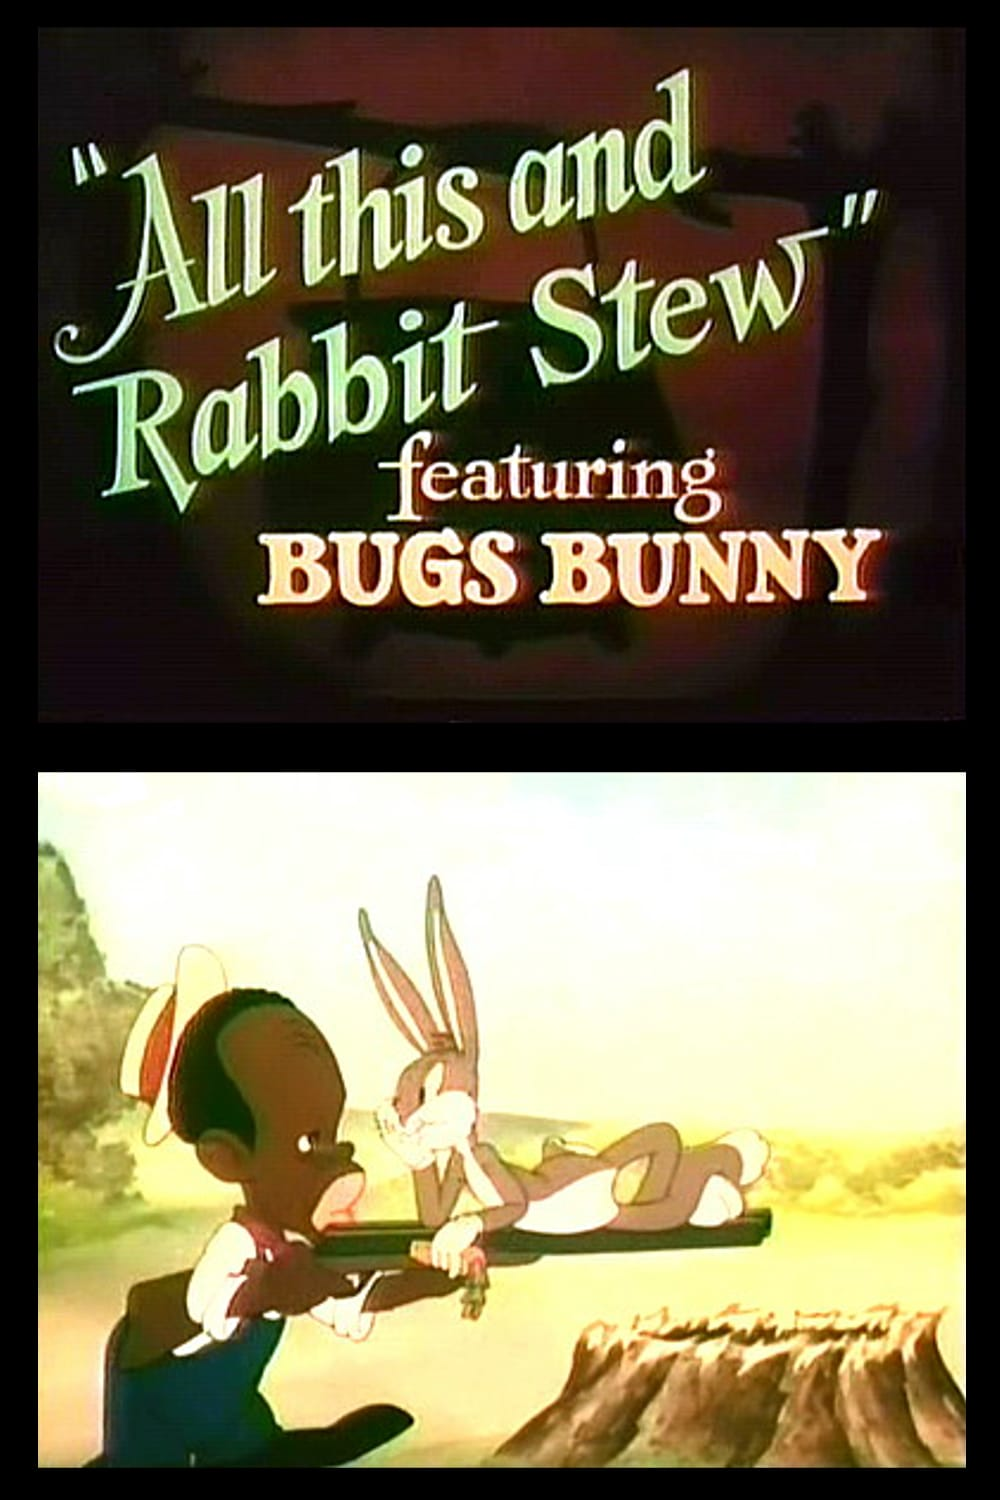

In [13]:
from IPython.display import Image
Image("../week-7/AllThisandRabbitStew.jpg", width=400, height=400)

I googled the poster for the movie that is most similar to "gun". The images suggests this is pretty accurate.

In [212]:
#look at top 5 words most similar to document
wikiD2V.most_similar([ wikiD2V.docvecs['The Great Train Robbery'] ], topn=5) 

[('result', 0.9986819624900818),
 ('appear', 0.9982242584228516),
 ('cards', 0.998126745223999),
 ('trade', 0.9981080889701843),
 ('dig', 0.9980885982513428)]

In [106]:
#look at top 5 words most similar to document
wikiD2V.most_similar([ wikiD2V.docvecs['Alice in Wonderland'] ], topn=5) 

[('responds', 0.9982626438140869),
 ('hearing', 0.997337818145752),
 ('moved', 0.997065544128418),
 ('forcing', 0.9970295429229736),
 ('unexpectedly', 0.9970152378082275)]

In [107]:
# top 5 documents most similar to multiple words
wikiD2V.docvecs.most_similar([ wikiD2V['gun']+wikiD2V['death']+wikiD2V['town']], topn=5 )

[('Code of the Streets', 0.9888991117477417),
 ('The Champion', 0.9886534214019775),
 ('Angels with Dirty Faces', 0.9855630397796631),
 ('The Rough House', 0.9850116968154907),
 ('Brother Orchid', 0.9848062992095947)]

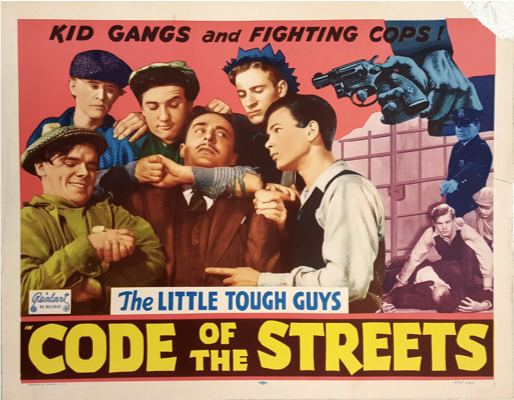

In [14]:
Image("../week-7/Picture1.png", width=400, height=400)

I googled the first movie "Code of the Streets" and it is also pretty accurate. 

In [245]:
# heatmap with keywords
heatmapMatrix1 = []
for tagOuter in movie_keywords:
    column = []
    tagVec = wikiD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in movie_keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, wikiD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix1.append(column)
heatmapMatrix1 = np.array(heatmapMatrix1)

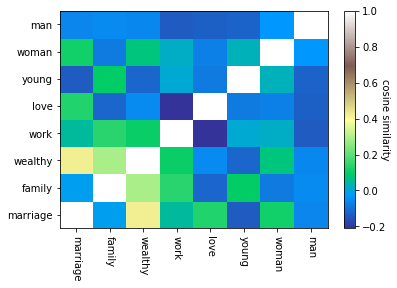

In [246]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix1, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix1.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix1.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(movie_keywords, minor=False, rotation=270)
a = ax.set_yticklabels(movie_keywords, minor=False)

This heatmap interesting shows that the two words with highest cosine similarity are wealthy and marriage. This seems to suggests that in the semantic world of movies, marriage is a way to move up the social ladder because it is semantically relatively similar to wealthy.
Another pattern to be noted is that love and work seems to have the lowest cosine similarity. This suggests that love in the movies might locate in a different semantic space than work. For instance, while love exists in the domestic semantic space, work exists outside of it. 

In [252]:
# heatmap with last 10 movies
targetMovs = wiki_df_2['Title'][:100:10]
#targetMovs = wiki_df_2['Title'][:10]
heatmapMatrixD = []

for tagOuter in targetMovs:
    column = []
    tagVec = wikiD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetMovs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, wikiD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

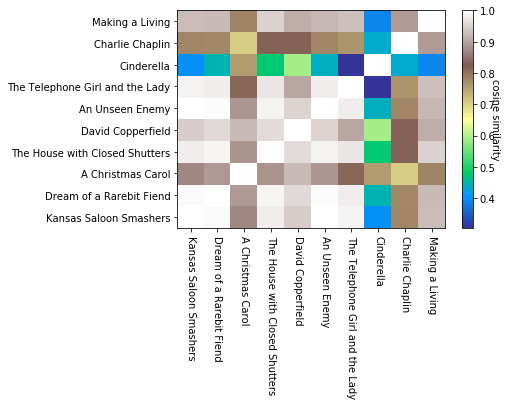

In [253]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetMovs, minor=False, rotation=270)
a = ax.set_yticklabels(targetMovs, minor=False)

I actually tried the heatmap with two samples. In the first sample I experimented with the first 10 movies in my dataframe and the heatmap indicated that all of them are very similar, with cosine similarity scores above 0.94. 

The second heatmap (displayed here) uses the every 10th movie in the first 100 movies. And it shows that except for Cinderella and The Telephone Girl and the Lady, all the rest of the movies are similar. My guess is that the story of Cinderella is a fairy tale while the other movies might be more realistic. I'm not sure about The Telephone Girl and the Lady. Wikipedia page of the movie says it's an indie movie. 

In [254]:
# heatmap of first 10 docs and keywords
heatmapMatrixC = []

for tagOuter in targetMovs:
    column = []
    tagVec = wikiD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in movie_keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, wikiD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

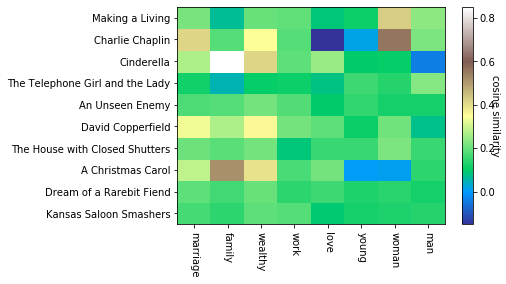

In [255]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(movie_keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetMovs, minor=False)

This heatmap shows that Charlie Chaplin the movie is most dissimilar with the word vector of love. This might because the movie is a biographical documentary and not a love story. 

# Projection

We can also project word vectors to an arbitray semantic dimension. To demonstrate this possibility, let's first load a model trained with New York Times news articles. 

In [114]:
nytimes_model = gensim.models.KeyedVectors.load_word2vec_format('../data/nytimes_cbow.reduced.txt')

First we can visualize with dimension reduction

In [115]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix

In [118]:
print(tnytTargetWords)
len(tnytTargetWords)

['man', 'him', 'he', 'woman', 'her', 'she', 'black', 'blacks', 'African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive', 'doctor', 'lawyer', 'plumber', 'scientist', 'hairdresser', 'nanny', 'carpenter', 'entrepreneur', 'musician', 'writer', 'banker', 'poet', 'nurse', 'steak', 'bacon', 'croissant', 'cheesecake', 'salad', 'cheeseburger', 'vegetables', 'beer', 'wine', 'pastry', 'basketball', 'baseball', 'boxing', 'softball', 'volleyball', 'tennis', 'golf', 'hockey', 'soccer']


54

In [117]:
wordsSubMatrix # wordsSubMatrix is the matrix that stores all the key words trained by the model? 

array([[-0.343139, -0.117117, -0.50773 , ..., -0.995696,  0.921299,
         0.943769],
       [-0.362909, -0.263528,  0.032661, ..., -0.043032, -0.178965,
         0.353556],
       [-0.70167 , -0.344525, -0.320714, ...,  0.009001,  0.11055 ,
         0.751077],
       ...,
       [-2.391626, -1.90143 ,  1.031182, ...,  2.947464,  1.01588 ,
         2.00033 ],
       [-2.432387, -1.161415,  1.060064, ...,  4.402381,  0.500471,
         1.644596],
       [ 0.981931,  0.628094, -0.747547, ...,  1.612927,  1.148063,
         1.063776]], dtype=float32)

In [122]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

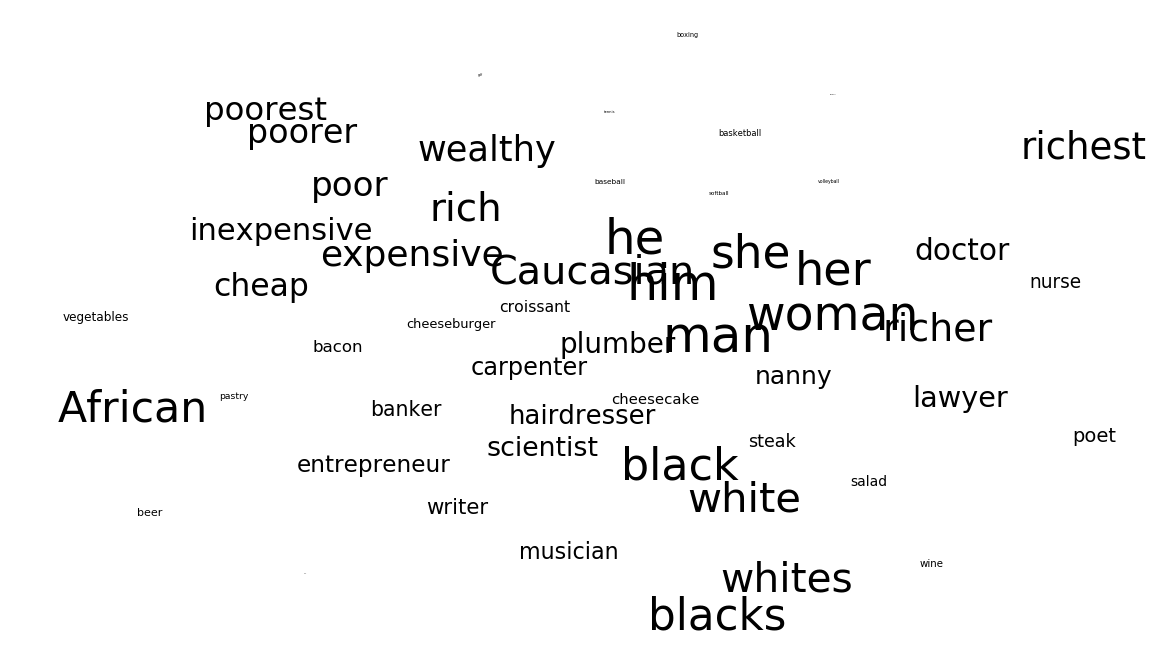

In [123]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  50 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions. 

In [124]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives]) #means whatever the model returns will be a vector
    return diff
# sum the normalized vector of each modeled word in positives list - sum of the normalized vector of each word in the negative list
# (X1+X2+X3) - (Y1+Y2+Y3)

Let's calculate three dimensions: gender, race, and class.

In [125]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])


# gender, race, class, each of them are vectors (differences between (summ of normalized vectors of each modeled word in positive list - sum of ... in negative list))

In [127]:
#Class.shape

(300,)

Here we have some words.

In [53]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [54]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df
#to project each word in the word list, i.e. occupations, foods, sports, to the three dimensions (gender, race, class)

Get the projections.

In [55]:
OCCdf = makeDF(nytimes_model, Occupations) #for word in occupation word list, train the word using the nytimes_model and calculate the cosine similarity bet the reshaped array
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

Define some useful functions for plotting.

In [56]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim): #dim stands for dimension
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

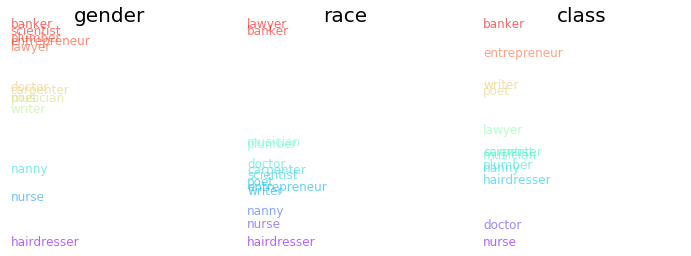

In [57]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

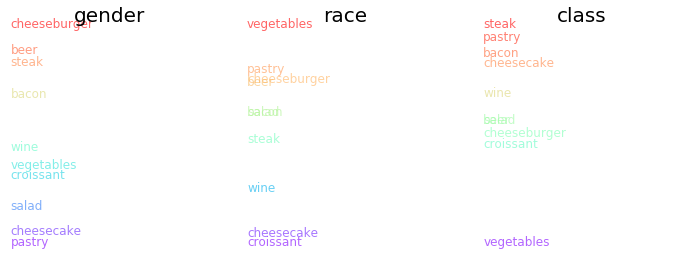

In [58]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

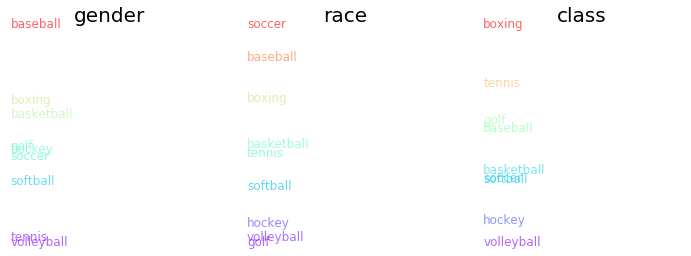

In [59]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project, then generate meaningful semantic dimensions based on your theoretical understanding of the semantic space (i.e., by subtracting semantically opposite word vectors) and project another set of word vectors onto those dimensions. Interpret the meaning of these projections for your analysis. Which of the dimensions you analyze explain the most variation in the projection of your words and why? 

<span style="color:red">***Stretch***: Average together multiple antonym pairs to create robust semantic dimensions. How do word projections on these robust dimensions differ from single-pair dimensions?

In [ ]:
#word2vec model
#wiki_W2V


In [133]:
#look at wiki_W2V's vacabulary # wv.vocab returns a dictionary
wiki_W2V.wv.vocab

{'bartender': <gensim.models.keyedvectors.Vocab at 0x1a43020f50>,
 'working': <gensim.models.keyedvectors.Vocab at 0x1a3b8dfa50>,
 'saloon': <gensim.models.keyedvectors.Vocab at 0x1a3b8df8d0>,
 'serving': <gensim.models.keyedvectors.Vocab at 0x1a3060d2d0>,
 'drinks': <gensim.models.keyedvectors.Vocab at 0x1a3060d990>,
 'customers': <gensim.models.keyedvectors.Vocab at 0x1a305d7dd0>,
 'fills': <gensim.models.keyedvectors.Vocab at 0x1a3b34b110>,
 'irish': <gensim.models.keyedvectors.Vocab at 0x1a3b34b090>,
 'man': <gensim.models.keyedvectors.Vocab at 0x1a3060d310>,
 'bucket': <gensim.models.keyedvectors.Vocab at 0x1a3060d4d0>,
 'beer': <gensim.models.keyedvectors.Vocab at 0x1a3b349ad0>,
 'carrie': <gensim.models.keyedvectors.Vocab at 0x1a3b349710>,
 'nation': <gensim.models.keyedvectors.Vocab at 0x1a3ab0d610>,
 'followers': <gensim.models.keyedvectors.Vocab at 0x1a3ab0d210>,
 'burst': <gensim.models.keyedvectors.Vocab at 0x1a3ab0d510>,
 'inside': <gensim.models.keyedvectors.Vocab at 0x1a

In [141]:
'she' in wiki_W2V.wv.vocab
   

False

In [150]:
#words to create dimensions
tnytTargetWords = ['father','mother','son','daughter','wife','husband','man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
wikiTargetWords = []
for word in tnytTargetWords:
    if word in wiki_W2V.wv.vocab:
        wikiTargetWords.append(word)
        
print(wikiTargetWords)

['father', 'mother', 'son', 'daughter', 'wife', 'husband', 'man', 'woman', 'black', 'white', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'cheap']


In [151]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]
wikiOccupations = []
for word in Occupations:
    if word in wiki_W2V.wv.vocab:
        wikiOccupations.append(word)
print(wikiOccupations)

['doctor', 'lawyer', 'plumber', 'scientist', 'hairdresser', 'nanny', 'carpenter', 'musician', 'writer', 'banker', 'poet', 'nurse']


In [ ]:
#Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


In [ ]:
#age = ['young','old','youthful','elderly','']

In [152]:
#words I will use for mapping
wikiTargetWords += wikiOccupations
print(wikiTargetWords)

['father', 'mother', 'son', 'daughter', 'wife', 'husband', 'man', 'woman', 'black', 'white', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'cheap', 'doctor', 'lawyer', 'plumber', 'scientist', 'hairdresser', 'nanny', 'carpenter', 'musician', 'writer', 'banker', 'poet', 'nurse']


In [155]:
len(wikiTargetWords)

29

In [153]:
#subMatrix
wordsSubMatrix = []
for word in wikiTargetWords:
    wordsSubMatrix.append(wiki_W2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)



In [156]:
# pca dimension reduction for submatrix

pcaWordsWIKI = sklearn.decomposition.PCA(n_components = 29).fit(wordsSubMatrix)
reducedPCA_dataWIKI = pcaWordsWIKI.transform(wordsSubMatrix)

tsneWordsWIKI = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataWIKI)

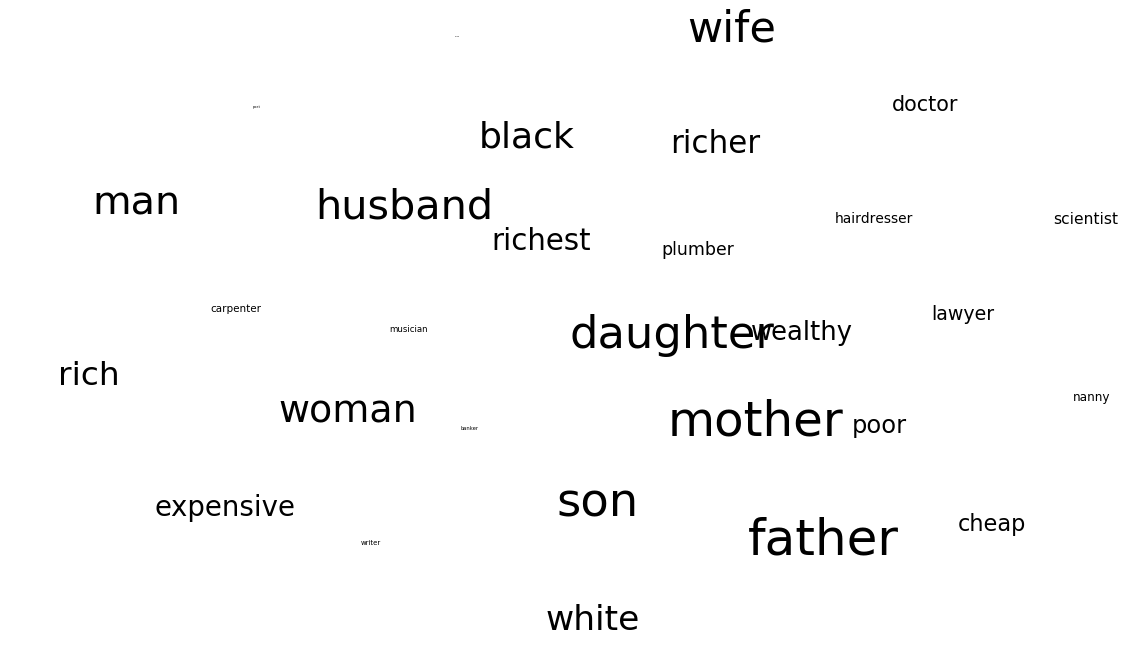

In [157]:
# plot word embedding in submatrix

fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsWIKI[:, 0], tsneWordsWIKI[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(wikiTargetWords):
    ax.annotate(word, (tsneWordsWIKI[:, 0][i],tsneWordsWIKI[:, 1][i]), size =  50 * (len(wikiTargetWords) - i) / len(wikiTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

The plot interesting shows that "fathter" is located near "cheap", mother is located near "poor" while "daughter" is located near "wealthy" and "husband" near "richest". I wonder if this suggests the semantic space of the movie plots portrays marriage as a way for poor family (the daughter's original family of poor mother and fathers) to move up the social ladder (to marry wealthy husband).

In [158]:
#functions 

def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives]) #means whatever the model returns will be a vector
    return diff
# sum the normalized vector of each modeled word in positives list - sum of the normalized vector of each word in the negative list
# (X1+X2+X3) - (Y1+Y2+Y3)

In [181]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df
#to project each word in the word list, i.e. occupations, foods, sports, to the three dimensions (gender, race, class)

In [182]:
#functions for plotting
def Coloring(Series):
    x = Series.values
    y = x-x.min()#[-1, 2, 3, 4, 5] - -1 = [0, 3, 4, 5, 6] # values in y is >= 0
    z = y/y.max() # [0, 1/2, 2/3, 5/6, 1]
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim): #dim stands for dimension
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

In [183]:
#calculate the vectors of gender, race, and class
Gender = dimension(wiki_W2V, ['man','son','father'], ['woman', 'daughter', 'mother'])
Race = dimension(wiki_W2V, ['black'], ['white'])
Class = dimension(wiki_W2V, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'cheap'])


# gender, race, class, each of them are vectors (differences between (summ of normalized vectors of each modeled word in positive list - sum of ... in negative list))

In [256]:
print(wikiOccupations)

['doctor', 'lawyer', 'plumber', 'scientist', 'hairdresser', 'nanny', 'carpenter', 'musician', 'writer', 'banker', 'poet', 'nurse']


In [185]:
# some word list to be mapped onto the dimensions
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","musician","writer", "banker","poet","nurse"]

#Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

#Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

In [186]:
# get projection dataframe
OCCdfWIKI = makeDF(wiki_W2V, wikiOccupations) #for word in occupation word list, train the word using the nytimes_model and calculate the cosine similarity bet the reshaped array
#Fooddf = makeDF(nytimes_model, Foods)
#Sportsdf = makeDF(nytimes_model, Sports)

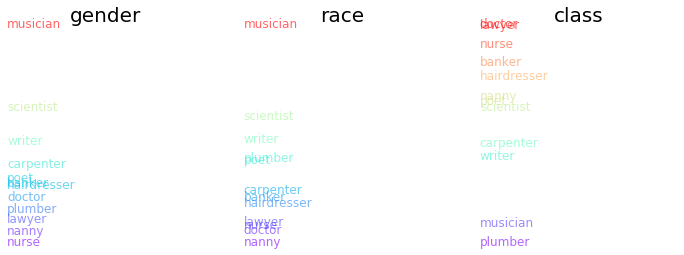

In [187]:
# plot word list in each dimensions
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdfWIKI, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdfWIKI, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdfWIKI, 'class')
plt.show()

This graph shows that in the first dimension gender, musicians are more likely to be man while nanny and nurse are more likely to be woman. The race dimension suggests that in my corpus, musicians are more likely to be black, while lawyer, doctor, nanny are more likely to be white. The class dimension shows that lawyer and doctors are more likely to be of upper class while musicians and plumber are more likely to be poor. 

# The Score Function

The score function is a simple calculation developed by [Matt Taddy](https://arxiv.org/pdf/1504.07295.pdf) to calculate the likelihood that a given text would have been generated by a word-embedding model by summing the inner product between each pair of the text's word vectors. This relies on a few data files that are not in the git repo due to their size please download and unzip [this](https://github.com/Computational-Content-Analysis-2018/Upcoming/raw/master/data/supplement.zip) (472MB) file in the data directory.

Here, we explore this using a model trained with millions of resumes from the CareerBuilder website (we can't share the private resumes...but we can share a model built with them :-):

We can examine the vacabularies of this model by building a word-index map:

In [ ]:
resume_model  = gensim.models.word2vec.Word2Vec.load('../data/resumeAll.model')

In [61]:
vocab = resume_model.wv.index2word

Let's just load the sample and take a look at it. The sentences in each job description are already tokenized and normalized.

In [62]:
sampleDF = pandas.read_csv('../data/SampleJobAds.csv', index_col = False)
#We need to convert the last couple columns from strings to lists
sampleDF['tokenized_sents'] = sampleDF['tokenized_sents'].apply(lambda x: eval(x))
sampleDF['normalized_sents'] = sampleDF['normalized_sents'].apply(lambda x: eval(x))
sampleDF

,Unnamed: 0,hiringOrganization_organizationName,jobDescription,jobLocation_address_region,jobLocation_geo_latitude,jobLocation_geo_longitude,qualifications,responsibilities,tokenized_sents,normalized_sents
0,158844,"Golfsmith International, Inc.","""Sales Associate Tracking Code 220425-971 Job ...",California,33.91918,-118.41647,NaN,"""Ensure each Customer receives exceptional ser...","[[``, Sales, Associate, Tracking, Code, 220425...","[[sales, associate, tracking, code, job, descr..."
1,257645,Intel,For PHY system engineering team within the Wir...,NaN,NaN,NaN,NaN,NaN,"[[For, PHY, system, engineering, team, within,...","[[for, phy, system, engineering, team, within,..."
2,107875,Florida Hospital,*RN Medical Oncology PCU Orlando - Nights* Flo...,Florida,28.53834,-81.37924,NaN,NaN,"[[*RN, Medical, Oncology, PCU, Orlando, -, Nig...","[[medical, oncology, pcu, orlando, florida, ho..."
3,202394,Hitachi Data Systems,Title: Specialist Sales Account Representative...,NaN,NaN,NaN,NaN,NaN,"[[Title, :, Specialist, Sales, Account, Repres...","[[title, specialist, sales, account, represent..."
4,109675,Footprint Retail Services,**Footprint Retail Services** **Job Descriptio...,NaN,NaN,NaN,NaN,A Merchandiser must complete all assigned merc...,"[[**Footprint, Retail, Services**, **Job, Desc...","[[retail, job, title, retail, merchandiser, re..."
5,215973,Home Depot,Position Purpose: Provide outstanding service ...,Indiana,41.13060,-85.12886,NaN,Provide outstanding service to ensure efficien...,"[[Position, Purpose, :, Provide, outstanding, ...","[[position, purpose, provide, outstanding, ser..."
6,207524,Home Depot,The Asset Protection Specialist is primarily r...,New Jersey,40.21455,-74.61932,Must be eighteen years of age or older. Must p...,NaN,"[[The, Asset, Protection, Specialist, is, prim...","[[the, asset, protection, specialist, is, prim..."
7,64426,East West Bank,# Job Description East West Bank is one of the...,California,34.06862,-118.02757,NaN,We are currently seeking a Customer Service Ce...,"[[#, Job, Description, East, West, Bank, is, o...","[[job, description, east, west, bank, is, one,..."
8,245192,IBM,Job Description IBM is seeking to hire a Senio...,NaN,NaN,NaN,NaN,NaN,"[[Job, Description, IBM, is, seeking, to, hire...","[[job, description, ibm, is, seeking, to, hire..."
9,202429,Hitachi Data Systems,Title: Field Solutions Engineer Location: New ...,NaN,NaN,NaN,NaN,Job Functions;Specific duties in this role wil...,"[[Title, :, Field, Solutions, Engineer, Locati...","[[title, field, solutions, engineer, location,..."


In [ ]:
# tokenizd
# "[for, phy, s...]" # for csv 
# eval("[for, phy, s...]") -> [[for, phy], [s...]]

Let's define a function to calculate the likelihood of each job description. The idea is borrowed from [Matt Taddy](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/deepir.ipynb), who shows how a document can be characterized as the inner product of the distance between its words. In other words, this analysis will show which job ads are most likely to find an appropriate pool of workers in the resume bank that generated our word embedding.  

In [63]:
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

Let's apply this function to every job description.

In [64]:
sampleDF['likelihood'] = sampleDF['normalized_sents'].apply(lambda x: adprob(x, resume_model))

Let's take a look at the top 5 job descriptions that have the highest likelihood.

In [65]:
for ad in sampleDF.sort_values(by = 'likelihood', ascending = False)['jobDescription'][:5]:
    print (ad + '\n\n')

Project Engineering including below jobs: 1. Hardware designing of DCS 2. Software configurations, programming, testing of DCS/PLC 3. Testing and FAT 4. Installation and commissioning. 5. Material ordering, approvals of datasheets. 6. HSE compliance as per HSE directives of HON. BE / B. Tech - Instrumentation / Control / Electronics. **Job:** **Engineering* **Title:** *Systems Engineer* **Location:** *IND-MH-Pune* **Requisition ID:** *00302235*


Like talking on the phone? Enjoy giving great customer service? Use those skills while working flexible,part time hours.


*# Positions:* 2 *Location:* US - UT - Orem *Category:* Engineering


Title: Respiratory Therapy, Intern Location: XX-XX-XX


Title: Position Opening at Illinois Wesleyan University Location: US-IL-Bloomington




Let's take a look at the bottom 5 job descriptions that have the lowest likelihood to be matched by the resumes.

In [66]:
for ad in sampleDF.sort_values(by = 'likelihood')['jobDescription'][:5]:
    print (ad + '\n\n')

Title: Contract Svc Admin Location: United States\-Michigan\-Caledonia Other Locations: JOB SUMMARY: ESSENTIAL DUTIES AND RESPONSIBILITIES: _ Other duties may be assigned:_ Prepare GPO rebate data for upload into STARR system oEnsure accurate data loads oProcess data into required reports oEnsure that GPOs are paid accurately and timely Prepare Sales Tracing data for upload into STARR system oEnsure accurate data loads oProcess data into required reports Prepare Rebate data for upload into STARR system oEnsure accurate data loads oProcess data into required reports oEnsure that distributors are accurately taking rebates against open invoices Manage work flow throughout the sales contracting process Ensure compliance with contract policies and performance requirements Assist in the preparation of charts and sales reports and analytics for customers and Management oQuarterly Reports oSales Tracing Answers customers and internal sale/customer service staff questions regarding pricing Mana

We can do the same for phrases corresponding to job skills.

In [67]:
adprob([["python", "programming"]], resume_model)

-14.355247

In [68]:
adprob([["julia", "programming"]], resume_model)

-33.427353

Basic programming appears to be more likely in this pool of resumes than python programming. 

We can also do some simple statistics. Unfortunately, we don't have a large sample here. Nevertheless, let's first look at the mean likelihood score of each hiring organization. Some organizations will do well to hire on CareerBuilder...while others will not.

In [69]:
sampleDF.groupby("hiringOrganization_organizationName")[['likelihood']].mean().sort_values('likelihood', ascending = False)

,likelihood
hiringOrganization_organizationName,
Honeywell,-25.974749
Legrand North America,-40.500500
Franciscan St. Eilzabeth Health,-43.167206
Illinois Wesleyan University,-52.681591
Gold's Gym,-75.230896
Jewel-Osco,-80.965462
Ingersoll Rand,-81.494949
Kaiser Permanente,-85.523113
Hallmark Health,-86.037094


We can also look at the mean likelihood of each state.

In [70]:
sampleDF.groupby("jobLocation_address_region")[['likelihood']].mean().sort_values('likelihood', ascending = False)

,likelihood
jobLocation_address_region,
Utah,-40.500500
Montana,-63.730721
Connecticut,-67.623466
Kansas,-85.259682
Tennessee,-93.188822
Illinois,-93.989101
New Hampshire,-94.109772
Georgia,-102.271820
South Carolina,-103.527328


You would increase the sample size if you want to do a more serious study.

## <span style="color:red">*Exercise 4a*</span>

<span style="color:red">**Do only 4a or 4b.** Construct cells immediately below this that calculate the scores for a small sample of documents from outside your corpus to identify which are *closest* to your corpus. Then calculate the scores for a few phrases or sentences to identify the ones most likely to have appeared in your corpus. Interrogate patterns associated with these document/phrase scores (e.g., which companies produced job ads most or least likely to find jobseekers in the resume corpus?) What do these patterns suggest about the boundaries of your corpus?

The outside corpus I use for this exercise is a corpus of blogposts downloaded from Kaggle. My idea is to use this outside corpus to find which blogposts are likely to be generated by my movie plot word to vec model and hence the post writers are more likely to watch movies. That is, to identify which blog post writers will be interested in watching movies from my sample that include movies from 1901 to 1943.

In [ ]:
# model
wiki_W2V

In [8]:
# import sample dataset 
blog_df = pandas.read_csv(os.path.join(os.getcwd(), 'blogtext.csv'))

In [9]:
blog_df.head(20)

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...
5,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",I had an interesting conversation...
6,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",Somehow Coca-Cola has a way of su...
7,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004","If anything, Korea is a country o..."
8,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",Take a read of this news article ...
9,3581210,male,33,InvestmentBanking,Aquarius,"09,June,2004",I surf the English news sites a l...


In [286]:
blog_df.shape

(681284, 7)

In [287]:
# since the dataframe seems to be grouped by the age and topic column, I will choose every tenth of the first 5000 blogposts as my sample to cover a wider range of posts from different age and topic. 
blog_df_1 = blog_df[1:5000:10]

In [288]:
blog_df_1.head(10)

,id,gender,age,topic,sign,date,text
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
11,3581210,male,33,InvestmentBanking,Aquarius,"09,June,2004",If you click on my profile you'll...
21,3581210,male,33,InvestmentBanking,Aquarius,"14,June,2004",My wife posed a strange question ...
31,3581210,male,33,InvestmentBanking,Aquarius,"29,June,2004",urlLink The business class ta...
41,3581210,male,33,InvestmentBanking,Aquarius,"05,July,2004",One of my favorite places in 여의도 ...
51,3581210,male,33,InvestmentBanking,Aquarius,"20,July,2004","Ah, urlLink the monsoon season h..."
61,3581210,male,33,InvestmentBanking,Aquarius,"04,August,2004",Seoul is a pretty good place for ...
71,3581210,male,33,InvestmentBanking,Aquarius,"09,August,2004","Ah, finally...someone else I know..."
81,3539003,female,14,indUnk,Aries,"11,August,2004",You may be wondering why my s...
91,3539003,female,14,indUnk,Aries,"11,August,2004",Death can be a scary thing. I...


In [289]:
#proprocessing 
blog_df_1['tokenized_sents'] = blog_df_1['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
blog_df_1['normalized_sents'] = blog_df_1['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])



/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [290]:
blog_df_1.head(10)

,id,gender,age,topic,sign,date,text,tokenized_sents,normalized_sents
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...,"[[These, are, the, team, members], [Drewes, va...","[[team, members], [drewes, van, der, laag], [u..."
11,3581210,male,33,InvestmentBanking,Aquarius,"09,June,2004",If you click on my profile you'll...,"[[If, you, click, on, my, profile, you, 'll, m...","[[click, profile, startling, discovery], [born..."
21,3581210,male,33,InvestmentBanking,Aquarius,"14,June,2004",My wife posed a strange question ...,"[[My, wife, posed, a, strange, question, to, m...","[[wife, posed, strange, question, tonight], [a..."
31,3581210,male,33,InvestmentBanking,Aquarius,"29,June,2004",urlLink The business class ta...,"[[urlLink], [The, business, class, tag, for, b...","[[urllink], [business, class, tag, baggage], [..."
41,3581210,male,33,InvestmentBanking,Aquarius,"05,July,2004",One of my favorite places in 여의도 ...,"[[One, of, my, favorite, places, in, 여의도], [Ye...","[[favorite, places, 여의도], [yeouido], [urllink]..."
51,3581210,male,33,InvestmentBanking,Aquarius,"20,July,2004","Ah, urlLink the monsoon season h...","[[Ah, urlLink], [the, monsoon, season, has, en...","[[ah, urllink], [monsoon, season, ended, begin..."
61,3581210,male,33,InvestmentBanking,Aquarius,"04,August,2004",Seoul is a pretty good place for ...,"[[Seoul, is, a, pretty, good, place, for, outd...","[[seoul, pretty, good, place, outdoor, activit..."
71,3581210,male,33,InvestmentBanking,Aquarius,"09,August,2004","Ah, finally...someone else I know...","[[Ah, finally], [someone, else, I, know, is, c...","[[ah, finally], [know, coming, canada, visit],..."
81,3539003,female,14,indUnk,Aries,"11,August,2004",You may be wondering why my s...,"[[You, may, be, wondering, why, my, site, is, ...","[[wondering, site, called, spaghetti, wall], [..."
91,3539003,female,14,indUnk,Aries,"11,August,2004",Death can be a scary thing. I...,"[[Death, can, be, a, scary, thing], [It, only,...","[[death, scary, thing], [like, know, little], ..."


In [291]:
# function
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

In [292]:
# apply function to each normalized sents
blog_df_1['likelihood'] = blog_df_1['normalized_sents'].apply(lambda x: adprob(x, wiki_W2V))

/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [293]:
blog_df_1.head(10)

,id,gender,age,topic,sign,date,text,tokenized_sents,normalized_sents,likelihood
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...,"[[These, are, the, team, members], [Drewes, va...","[[team, members], [drewes, van, der, laag], [u...",-10.441392
11,3581210,male,33,InvestmentBanking,Aquarius,"09,June,2004",If you click on my profile you'll...,"[[If, you, click, on, my, profile, you, 'll, m...","[[click, profile, startling, discovery], [born...",-34.013329
21,3581210,male,33,InvestmentBanking,Aquarius,"14,June,2004",My wife posed a strange question ...,"[[My, wife, posed, a, strange, question, to, m...","[[wife, posed, strange, question, tonight], [a...",-59.266853
31,3581210,male,33,InvestmentBanking,Aquarius,"29,June,2004",urlLink The business class ta...,"[[urlLink], [The, business, class, tag, for, b...","[[urllink], [business, class, tag, baggage], [...",-21.768547
41,3581210,male,33,InvestmentBanking,Aquarius,"05,July,2004",One of my favorite places in 여의도 ...,"[[One, of, my, favorite, places, in, 여의도], [Ye...","[[favorite, places, 여의도], [yeouido], [urllink]...",-28.235962
51,3581210,male,33,InvestmentBanking,Aquarius,"20,July,2004","Ah, urlLink the monsoon season h...","[[Ah, urlLink], [the, monsoon, season, has, en...","[[ah, urllink], [monsoon, season, ended, begin...",-42.881645
61,3581210,male,33,InvestmentBanking,Aquarius,"04,August,2004",Seoul is a pretty good place for ...,"[[Seoul, is, a, pretty, good, place, for, outd...","[[seoul, pretty, good, place, outdoor, activit...",-47.795105
71,3581210,male,33,InvestmentBanking,Aquarius,"09,August,2004","Ah, finally...someone else I know...","[[Ah, finally], [someone, else, I, know, is, c...","[[ah, finally], [know, coming, canada, visit],...",-32.265759
81,3539003,female,14,indUnk,Aries,"11,August,2004",You may be wondering why my s...,"[[You, may, be, wondering, why, my, site, is, ...","[[wondering, site, called, spaghetti, wall], [...",-24.696234
91,3539003,female,14,indUnk,Aries,"11,August,2004",Death can be a scary thing. I...,"[[Death, can, be, a, scary, thing], [It, only,...","[[death, scary, thing], [like, know, little], ...",-34.407726


In [301]:
# look at the top 5 blog posts that have the highest likelihood
for ad in blog_df_1.sort_values(by = 'likelihood', ascending = False)['text'][:10]:
    print (ad + '\n\n')

           baak?         


           does he weep?           


           *blush*  I do my bestest.         


           hee hee funnnee.         


           yay!!!!!!!!  congratulations angie!!!!!!         


           wooooo!!!!!         


                Take my Quiz on QuizYourFriends.com!            


              urlLink    Mel and I at Dinner&nbsp; urlLink            


         that's Sama...     


   yo, yo, yo homeslices! 




In [295]:
# 5 job descriptions that have the lowest likelihood

for ad in blog_df_1.sort_values(by = 'likelihood')['text'][:5]:
    print (ad + '\n\n')

           the whole article:  urlLink http://www.washingtonpost.com/wp-dyn/articles/A23373-2004Jun7.html   Memo Offered Justification for Use of Torture  Justice Dept. Gave Advice in 2002  By Dana Priest and R. Jeffrey Smith Washington Post Staff Writers Tuesday, June 8, 2004; Page A01    In August 2002, the Justice Department advised the White House that torturing al Qaeda terrorists in captivity abroad 'may be justified,' and that international laws against torture 'may be unconstitutional if applied to interrogations' conducted in President Bush's war on terrorism, according to a newly obtained memo.          If a government employee were to torture a suspect in captivity, 'he would be doing so in order to prevent further attacks on the United States by the Al Qaeda terrorist network,' said the memo, from the Justice Department's office of legal counsel, written in response to a CIA request for legal guidance. It added that arguments centering on 'necessity and self-defense could p

This comparison shows that the blogposts with highest likelihood of be generated by my movie plot word2vec model are largely informal, conversational, dramatic, short, and the vocabulary used in these posts are very simple and most uses a lot of exclamation marks. The tone of these texts are more emotional than neutral. In comparison, the five posts with the least likelihood have a more neutral tone, the posts are much longer, and the vocabulary used have greater variety. These posts are also more formal instead of being conversational; they are more like essays while the posts with the highest likelihood are more like text messages.

In [296]:
# look for words/phrases
adprob([["fun", "sad"]], wiki_W2V)


-20.645933

In [297]:
# look for words/phrases
adprob([["phd", "professor"]], wiki_W2V)



-7.757412

In [302]:
adprob([["study", "school"]], wiki_W2V)



-15.074924

This comparison of words/phrases shows that words associated with emotions are more likely to be generated by my movie2vec model. Also, blog posts that wrote about phds and professors and academic are more likely to be generated by my model. This is a bit counterintuitive because the previous comparison shows that people who write shorter and less formal posts are more likely to watch movies and that people who write formal essays are less likely to watch movies. That is, it seems people are are in academia are less inclined to watch movies. But here it seems people who like to write about academic are also more likely to watch movies. I guess one interpretation to solve this contradiction is that the vocabulary in my model might have high frequency in using words associated with school; and that's why the likelihood of "phd", "professr", "school" have a high likelihood than emotional words such as "fun" and "sad".

In [298]:
#look at likelihood by age
blog_df_1.groupby("age")[['likelihood']].mean().sort_values('likelihood', ascending = False)

,likelihood
age,
15,-20.796547
24,-23.826334
36,-24.136535
17,-26.708054
16,-26.750282
34,-27.755650
45,-27.782948
35,-28.007347
14,-29.364882


In [299]:
#likelihood by topic
blog_df_1.groupby("topic")[['likelihood']].mean().sort_values('likelihood', ascending = False)

,likelihood
topic,
Banking,-11.952847
Arts,-22.497606
Student,-24.075113
BusinessServices,-24.839058
Engineering,-25.213571
indUnk,-26.924305
Technology,-28.190167
Science,-29.660489
Consulting,-32.566307


In [300]:
#likelihood by topic
blog_df_1.groupby("sign")[['likelihood']].mean().sort_values('likelihood', ascending = False)

,likelihood
sign,
Gemini,-19.493613
Taurus,-22.838605
Scorpio,-24.658238
Leo,-25.268280
Cancer,-25.976544
Libra,-26.643432
Aries,-27.715420
Pisces,-28.543995
Sagittarius,-29.832648


These three groupings indicate that people of all age groups are likely to watch movies. That is, age is not reflective of who are more likely to watch movies. But it seems people who like to write about banking are the most likely to watch movies. And just for fun, people who self-identify with Gemini are also more likely to watch movies compared to the rest.

# Linguistic Change or Difference

Below is code that aligns the dimensions of multiple embeddings arrayed over time or some other dimension and allow identification of semantic chanage as the word vectors change their loadings for focal words. This code comes from the approach piloted at Stanford by William Hamilton, Daniel Jurafsky and Jure Lescovec [here](https://arxiv.org/pdf/1605.09096.pdf). 

In [76]:
import copy

In [71]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

In order to explore this, let's get some data that follows a time trend. We'll look at conference proceedings from the American Society for Clinical Oncologists.

In [72]:
ascoDF = pandas.read_csv("../data/ASCO_abstracts.csv", index_col=0)

Prepare for wor2vec:

In [73]:
ascoDF['tokenized_sents'] = ascoDF['Body'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
ascoDF['normalized_sents'] = ascoDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

We will be creating many embeddings so we have created this function to do most of the work. It creates two collections of embeddings, one the original and one the aligned.

In [74]:
def compareModels(df, category, sort = True):
    """If you are using time as your category sorting is important"""
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF['normalized_sents'].sum())
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

Now we generate the models:

In [77]:
rawEmbeddings, comparedEmbeddings = compareModels(ascoDF, 'Year')

We need to compare them across all permutions so we will define another function to help, we will be using 1 - cosine similarity as that gives a more intitive range of 0-2 with low values meaning little change and high meaning lots of change.

In [78]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pandas.DataFrame(dists, index = cats)

Lets look at a couple words:

breast


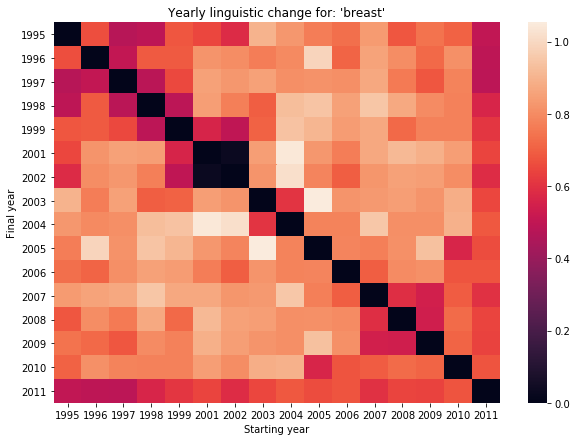

In [79]:
targetWord = 'breast'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

combination


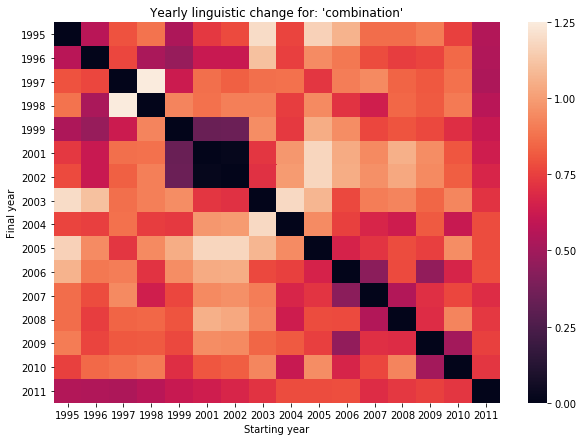

In [80]:
targetWord = 'combination'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [81]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)
    

In [82]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 1571 words to compare


The most divergent words are:

In [83]:
wordDivergences[:20]

[('t', 13.179612953215837),
 ('toxicity', 13.154180981218815),
 ('ml', 13.01737873442471),
 ('+', 12.853400095365942),
 ('activity', 12.749210256617516),
 ('infusion', 12.687976829707623),
 ('paclitaxel', 12.683675490319729),
 ('n', 12.662226218730211),
 ('great', 12.659880327060819),
 ('level', 12.559175675734878),
 ('x', 12.508285094052553),
 ('phase', 12.495868034660816),
 ('cisplatin', 12.456645250320435),
 ('combination', 12.417438723146915),
 ('c', 12.407136777415872),
 ('p', 12.399663124466315),
 ('efficacy', 12.373506214469671),
 ('csf', 12.333098318078555),
 ('show', 12.330282736569643),
 ('iv', 12.321207114960998)]

And the least:

In [84]:
wordDivergences[-20:]

[('answer', 1.7252497673034668),
 ('device', 1.721915602684021),
 ('facilitate', 1.720019280910492),
 ('additionally', 1.685628592967987),
 ('particular', 1.6720524430274963),
 ('ensure', 1.6524746417999268),
 ('context', 1.650183618068695),
 ('definition', 1.6107643842697144),
 ('difficulty', 1.6012009978294373),
 ('discuss', 1.5829300284385681),
 ('call', 1.5171823501586914),
 ('traditional', 1.4596245288848877),
 ('nature', 1.44323068857193),
 ('constitute', 1.4302696585655212),
 ('simple', 1.410505771636963),
 ('practical', 1.3745331764221191),
 ('special', 1.294035017490387),
 ('uncertain', 1.2042807936668396),
 ('situation', 1.1920225620269775),
 ('view', 1.1317378878593445)]

t


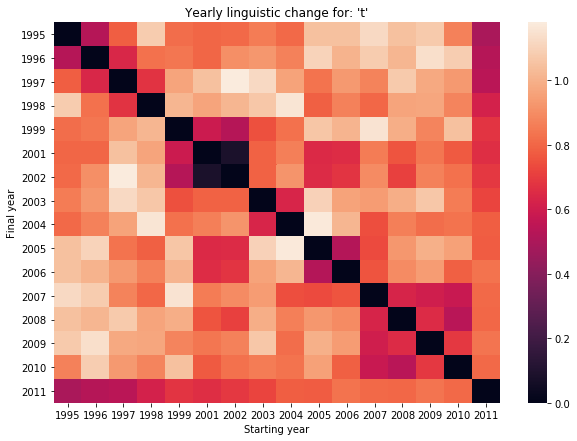

In [85]:
targetWord = wordDivergences[0][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

view


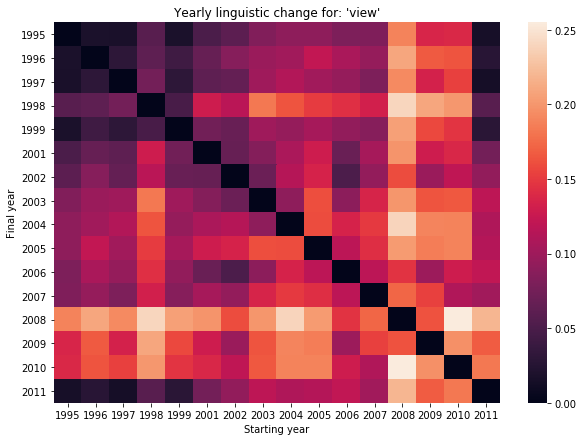

In [86]:
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

## Do the COHA example: Constrast 1800-1819 with 1900-1919 with 2000-2019

## <span style="color:red">*Exercise 4b*</span>

<span style="color:red">**Do only 4a or 4b.** Construct cells immediately below this that align word embeddings over time or across domains/corpora. Interrogate the spaces that result and ask which words changed most and least over the entire period or between contexts/corpora. What does this reveal about the social game underlying your space? 